This tutorial and the assets can be downloaded as part of the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/wallaroo2024.4_tutorials/wallaroo-observe/wallaro-model-observability-assays).

## Model Drift Observability with Assays

The Model Insights feature lets you monitor how the environment that your model operates within may be changing in ways that affect it's predictions so that you can intervene (retrain) in an efficient and timely manner. Changes in the inputs, **data drift**, can occur due to errors in the data processing pipeline or due to changes in the environment such as user preference or behavior. 

This notebook focuses on interactive exploration over historical data. After you are comfortable with how your data has behaved historically, you can schedule this same analysis (called an *assay*) to automatically run periodically, looking for indications of data drift or concept drift.

In this notebook, we will be running a drift assay on an ONNX model pre-trained to predict house prices.

* **IMPORTANT NOTICE**:  The following assumes Wallaroo Assays V2 are enabled.  This is the default setting for Wallaroo 2024.4 and later.  See [Set the Assay Version](https://docs.wallaroo.ai/wallaroo-model-operations/wallaroo-model-operations-observe/wallaroo-pipeline-assays/#set-the-assay-version) for more details.

## Goal

Model insights monitors the output of the spam classifier model over a designated time window and compares it to an expected baseline distribution. We measure the difference between  the window distribution and the baseline distribution; large differences indicate that the behavior of the model (or its inputs) has changed from what we expect. This possibly indicates a change that should be accounted for, possibly by retraining the models.

### Resources

This tutorial provides the following:

* Models:
  * `models/rf_model.onnx`: The champion model that has been used in this environment for some time.
  * Various inputs:
    * `smallinputs.df.json`: A set of house inputs that tends to generate low house price values.
    * `biginputs.df.json`: A set of house inputs that tends to generate high house price values.

### Prerequisites

* A deployed Wallaroo instance
* The following Python libraries installed:
  * [`wallaroo`](https://pypi.org/project/wallaroo/): The Wallaroo SDK. Included with the Wallaroo JupyterHub service by default.
  * [`pandas`](https://pypi.org/project/pandas/): Pandas, mainly used for Pandas DataFrame


## Steps

* Deploying a sample ML model used to determine house prices based on a set of input parameters.
* Build an assay baseline from a set of baseline start and end dates, and an assay baseline from a numpy array.
* Preview the assay and show different assay configurations.
* Upload the assay.
* View assay results.
* Pause and resume the assay.

### Import Libraries

The first step will be to import our libraries, and set variables used through this tutorial.

In [1]:
import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework

from IPython.display import display

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

import datetime
import time

workspace_name = f'assay-demonstration-tutorial-2'
main_pipeline_name = f'assay-demonstration-tutorial'
model_name_control = f'house-price-estimator'
model_file_name_control = './models/rf_model.onnx'

# Set the name of the assay
assay_name=f"house price assay demo v2"

# ignoring warnings for demonstration
import warnings
warnings.filterwarnings('ignore')

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

### Connect to the Wallaroo Instance

The first step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

In [2]:
# Login through local Wallaroo instance

wl = wallaroo.Client()

### Create Workspace

We will create a workspace to manage our pipeline and models.  The following variables will set the name of our sample workspace then set it as the current workspace.

Workspace, pipeline, and model names should be unique to each user, so we'll add in a randomly generated suffix so multiple people can run this tutorial in a Wallaroo instance without effecting each other.

In [3]:
workspace = wl.get_workspace(name=workspace_name, create_if_not_exist=True)

wl.set_current_workspace(workspace)

{'name': 'assay-demonstration-tutorial-2', 'id': 9, 'archived': False, 'created_by': '0c74dc8a-39cb-4b1e-8ba8-4013193b859b', 'created_at': '2024-12-19T16:23:09.211681+00:00', 'models': [], 'pipelines': []}

### Upload Model

For our example, we will upload the model that has been trained to derive house prices from a variety of inputs.  The model file is `rf_model.onnx`, and is uploaded with the name `house-price-estimator`.

In [4]:
housing_model_control = (wl.upload_model(model_name_control, 
                                        model_file_name_control, 
                                        framework=Framework.ONNX)
                                        .configure(tensor_fields=["tensor"])
                        )

### Build the Pipeline

This pipeline is made to be an example of an existing situation where a model is deployed and being used for inferences in a production environment.  We'll call it `assay-demonstration-tutorial`, set `housing_model_control` as a pipeline step, then run a few sample inferences.

This pipeline will be a simple one - just a single pipeline step.

In [5]:
mainpipeline = wl.build_pipeline(main_pipeline_name)
# # clear the steps if used before
mainpipeline.clear()

mainpipeline.add_model_step(housing_model_control)

#minimum deployment config
deploy_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(0.5).memory("1Gi").build()

mainpipeline.deploy(deployment_config = deploy_config, wait_for_status=False)

Deployment initiated for assay-demonstration-tutorial. Please check pipeline status.


name,assay-demonstration-tutorial
created,2024-12-19 16:23:10.022182+00:00
last_updated,2024-12-19 16:23:10.092884+00:00
deployed,True
workspace_id,9
workspace_name,assay-demonstration-tutorial-2
arch,x86
accel,none
tags,
versions,"891c2825-2a2a-41d5-9cc0-d163eba07225, 3d26461a-a803-4309-a956-3d1248b2d7af"
steps,house-price-estimator


In [6]:
# check the pipeline status before performing an inference

import time
time.sleep(15)

while mainpipeline.status()['status'] != 'Running':
    time.sleep(15)
    display(mainpipeline.status()['status'])

mainpipeline.status()

'Error'

'Starting'

'Starting'

'Running'

{'status': 'Running',
 'details': [],
 'engines': [{'ip': '10.28.2.2',
   'name': 'engine-79dbc8986-5fbxf',
   'status': 'Running',
   'reason': None,
   'details': [],
   'pipeline_statuses': {'pipelines': [{'id': 'assay-demonstration-tutorial',
      'status': 'Running',
      'version': '891c2825-2a2a-41d5-9cc0-d163eba07225'}]},
   'model_statuses': {'models': [{'model_version_id': 1,
      'name': 'house-price-estimator',
      'sha': 'e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6',
      'status': 'Running',
      'version': 'c24b3549-652b-4b83-988d-a33e18935df5'}]}}],
 'engine_lbs': [{'ip': '10.28.2.3',
   'name': 'engine-lb-6676794678-2mml6',
   'status': 'Running',
   'reason': None,
   'details': []}],
 'sidekicks': []}

### Testing

We'll use two inferences as a quick sample test - one that has a house that should be determined around `$700k`, the other with a house determined to be around `$1.5` million.

In [7]:
normal_input = pd.DataFrame.from_records({"tensor": [[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]]})
result = mainpipeline.infer(normal_input)
display(result)

,time,in.tensor,out.variable,anomaly.count
0,2024-12-19 16:24:26.042,"[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]",[718013.7],0


In [8]:
large_house_input = pd.DataFrame.from_records({'tensor': [[4.0, 3.0, 3710.0, 20000.0, 2.0, 0.0, 2.0, 5.0, 10.0, 2760.0, 950.0, 47.6696, -122.261, 3970.0, 20000.0, 79.0, 0.0, 0.0]]})
large_house_result = mainpipeline.infer(large_house_input)
display(large_house_result)

,time,in.tensor,out.variable,anomaly.count
0,2024-12-19 16:24:26.073,"[4.0, 3.0, 3710.0, 20000.0, 2.0, 0.0, 2.0, 5.0, 10.0, 2760.0, 950.0, 47.6696, -122.261, 3970.0, 20000.0, 79.0, 0.0, 0.0]",[1514079.4],0


### Generate Sample Data

Before creating the assays, we must generate data for the assays to build from.

For this example, we will:

* Perform sample inferences based on lower priced houses and use that as our baseline.
* Generate inferences from specific set of high priced houses create inference outputs that will be outside the baseline.  This is used in later steps to demonstrate baseline comparison against assay analyses.

#### Inference Results History Generation

To start the demonstration, we'll create a set of inferences based on houses with small estimated prices.

We will save the beginning and end periods of inferences to the variables `assay_baseline_start` and `assay_baseline_end`.  These will be used later to create assay baselines from a **range of dates**.

In [9]:
small_houses_inputs = pd.read_json('./data/smallinputs.df.json')
baseline_size = 500

# Where the baseline data will start
assay_baseline_start = datetime.datetime.now()

# These inputs will be random samples of small priced houses.  Around 30,000 is a good number
small_houses = small_houses_inputs.sample(baseline_size, replace=True).reset_index(drop=True)

# Wait 60 seconds to set this data apart from the rest
time.sleep(60)
small_results = mainpipeline.infer(small_houses)

# Set the baseline end

assay_baseline_end = datetime.datetime.now()

#### Generate Numpy Baseline Values

From our inference outputs, we will create an array of numpy values.  These are used for **assays baselines created from numpy values**.

In [10]:
# get the numpy values

# set the results to a non-array value
small_results_baseline_df = small_results.copy()
small_results_baseline_df['variable']=small_results['out.variable'].map(lambda x: x[0])
small_results_baseline_df

# set the numpy array
small_results_baseline = small_results_baseline_df['variable'].to_numpy()

#### Assay Test Data

The following will generate inference data for us to test against the assay baseline.  For this, we will add in house data that generate higher house prices than the baseline data we used earlier.

This process should take 6 minutes to generate the historical data we'll later use in our assays.  We store the DateTime `assay_window_start` to determine where to start out assay analyses.

In [11]:
# Get a spread of house values

# # Set the start for our assay window period.
assay_window_start = datetime.datetime.now()



for x in range(10):
    time.sleep(65)
    inference_size = 1000

    # And a spread of small house values

    small_houses_inputs = pd.read_json('./data/smallinputs.df.json', orient="records")
    small_houses = small_houses_inputs.sample(inference_size, replace=True).reset_index(drop=True)

    mainpipeline.infer(small_houses)

time.sleep(65)

In [12]:
# Get a spread of large house values

for x in range(10):
    time.sleep(65)
    inference_size = 1000

    # And a spread of large house values

    big_houses_inputs = pd.read_json('./data/biginputs.df.json', orient="records")
    big_houses = big_houses_inputs.sample(inference_size, replace=True).reset_index(drop=True)

    mainpipeline.infer(big_houses)

time.sleep(65)

## Model Insights via the Wallaroo Dashboard SDK

Assays generated through the Wallaroo SDK can be previewed, configured, and uploaded to the Wallaroo Ops instance.  The following is a condensed version of this process.  For full details see the [Wallaroo SDK Essentials Guide: Assays Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-assays/) guide.

Model drift detection with assays using the Wallaroo SDK follows this general process.

* Define the Baseline: From either historical inference data for a specific model in a pipeline, or from a pre-determine array of data, a **baseline** is formed.
* Assay Preview:  Once the baseline is formed, we **preview the assay** and configure the different options until we have the the best method of detecting environment or model drift.
* Create Assay:  With the previews and configuration complete, we **upload** the assay.  The assay will perform an analysis on a regular scheduled based on the configuration.
* Get Assay Results:  Retrieve the analyses and use them to detect model drift and possible sources.
* Pause/Resume Assay:  Pause or restart an assay as needed.

### Set the Assay Version

The assay version is set through [platform operations](https://docs.wallaroo.ai/wallaroo-platform-operations/wallaroo-platform-operations-configure/wallaroo-platform-operations-configure-enable-assay/), either during installation or via update.  Wallaroo platform engineers should inform users which assay version is being used.  For Wallaroo 2024.4, Assays V2 is the default.

The Wallaroo SDK is configured to use Assays V2 by setting the following environmental variable:

```bash
ASSAYS_V2_ENABLED=True|False
```

If `True` (*Default*), the Wallaroo SDK uses Wallaroo Assay V2.  If `False`, the Wallaroo SDK uses Wallaroo Assays V1.  This **must** match the same Assay setting set for through [platform operations](https://docs.wallaroo.ai/wallaroo-platform-operations/wallaroo-platform-operations-configure/wallaroo-platform-operations-configure-enable-assay/).  For the Wallaroo 2024.4 SDK, the SDK defaults to Assays V2; no environmental variable is required if using Assays V2.

### Define the Baseline

Assay baselines are defined with the [`wallaroo.client.build_assay`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/client/#Client.build_assay) method. Through this process we define the baseline from either a range of dates or pre-generated values.

`wallaroo.client.build_assay` take the following parameters:

| Parameter | Type | Description |
|---|---|---|
| **assay_name** | *String* (*Required*) - required | The name of the assay.  Assay names **must** be unique across the Wallaroo instance. |
| **pipeline** | *wallaroo.pipeline.Pipeline* (*Required*) | The pipeline the assay is monitoring. |
| **model_name** | *String* (*Optional*) / `None` | The name of the model to monitor.  This field should only be used to track the inputs/outputs for a specific model step in a pipeline.  If no `model_name` is to be included, then the parameters must be passed a named parameters not positional ones.   |
| **iopath**  |  String (Required) | The iopath of the assay in the format `"input/output {field_name} {field_index}"`, where field_index is required for list values and omitted for scalar values.  For example, to monitor the output list field house_price at index 0, the iopath is output house_price 0.   For data that are scalar values, no index is passed.  For example, the iopath for the input scalar field number_of_houses as an input is `'input number_of_houses'`. |
| **baseline_start** | *datetime.datetime* (*Optional*) | The start time for the inferences to use as the baseline.  **Must be included with `baseline_end`.  Cannot be included with `baseline_data`**. |
| **baseline_end** | *datetime.datetime* (*Optional*) | The end time of the baseline window. the baseline. Windows start immediately after the baseline window and are run at regular intervals continuously until the assay is deactivated or deleted.  **Must be included with `baseline_start`.  Cannot be included with `baseline_data`.**. |
| **baseline_data** | *[numpy.ndarray]* (*Optional*) | The baseline data in numpy array format.  **Cannot be included with either `baseline_start` or `baseline_data`**. |

Note that `model_name` is an optional parameters **when parameters are named**.  For example:

```python
assay_builder_from_dates = wl.build_assay(assay_name=assay_name, 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)
```

**or**:

```python
assay_builder_from_dates = wl.build_assay("assays from date baseline", 
                                          mainpipeline, 
                                          None, ## since we are using positional parameters, `None` must be included for the model parameter
                                          "output variable 0",
                                          assay_baseline_start, 
                                          assay_baseline_end)
```

Baselines are created in one of two **mutually exclusive** methods:

* **Date Range**:  The `baseline_start` and `baseline_end` retrieves the inference requests and results for the pipeline from the start and end period.  This data is summarized and used to create the baseline.  For our examples, we're using the variables `assay_baseline_start` and `assay_baseline_end` to represent a range of dates, with `assay_baseline_start` being set **before** `assay_baseline_end`.
* **Numpy Values**:  The `baseline_data` sets the baseline from a provided `List(numpy.ndarray)`.  This allows assay baselines to be created without first performing inferences in Wallaroo.

#### NaN Support

For `List(numpy.ndarray)` data that includes `nan` aka "Not a Number" (NaN), `nan` values are treated in Wallaroo assays as follows:

* **Visualizations**:  `nan` values are **not** discretely represented in visualizations.  These include methods including [Analysis Chart](#analysis-chart).
* **API Calls**:  `nan` in Wallaroo MLOps API calls and responses are handled as **null values**.  These include the following scenarios:
  * Baselines imports.
  * Querying baseline data.
  * Querying assays results in preview mode.
  * Querying assay results after assay upload and analysis.
* **Baseline metrics**: Baseline metrics created from imported values (aka numpy) and date based baselines from the Wallaroo Dashboard, the Wallaroo MLOps API, and the Wallaroo SDK are treated as follows:
  * Baseline stats **ignore** `nan` when calculating: `mean`, `median`, `std dev`, `min`, `max`
  * Baseline stats `include` `nan` when calculating `count`
* **Baseline binning** includes `nan` for:
  * [Score Metrics](#score-metric) of `PSI`, `SUMDIFF` `MAXDIFF` for both preview aka "interactive run" and post assay upload analysis factor `nan` values into the window score calculation and the associated [binning scheme](#binning-mode).
  * NaN’s are treated as **negative infinity** but included in the **left most bin**.

When creating an assay and uploading baseline values, `nan` are treated as the following.

For the **Wallaroo SDK** and **Wallaroo MLOps API**:  `nan` are treated as `null` values.

For example, the following represents a numpy array of scalar values with `nan` used to set the `baseline_data` parameter for `wallaroo.client.build_assay`:

```python
array([0.70193326, 0.47008988, 0.7616768 , 0.9431376 , 0.50103927,
              nan, 0.89329976,        nan,        nan,        nan,
       0.58292973, 0.48995697,        nan, 0.9030761 , 0.7702084 ,
       0.9390605 , 0.8298963 , 0.67003745,        nan,        nan,
       0.74228466, 0.86391646, 0.6272545 , 0.98149616, 0.5447043 ,
       0.77968633, 0.9667691 , 0.5470645 , 0.37201208,        nan,
       0.9306987 , 0.8555044 , 0.4436646 , 0.9368085 , 0.37693697,
       0.577266  , 0.92817307, 0.75857186, 0.38707468, 0.47264728,
              nan, 0.71578735, 0.61894614, 0.64258444, 0.5291687 ,
       0.6411414 , 0.916696  , 0.9529305 , 0.8856967 , 0.9972307 ,
              nan, 0.8239512 , 0.7381674 , 0.71604645,        nan,
       0.47042927, 0.74200916, 0.48061103, 0.94891435, 0.3890468 ,
       0.8650436 , 0.86701703, 0.8704494 , 0.59858173, 0.51502967,
              nan, 0.5377161 , 0.769263  ,        nan, 0.5234249 ,
       0.93986815, 0.7800815 , 0.4801252 , 0.8666868 , 0.84256464,
              nan,        nan, 0.7632106 , 0.5735948 , 0.7882653 ,
       0.89087194, 0.42760596, 0.9458847 , 0.81456304, 0.90949756,
       0.3479154 , 0.51345766, 0.9211736 , 0.9210087 , 0.7888714 ,
       0.88118184, 0.8678766 , 0.89132327, 0.8414709 , 0.8166902 ,
       0.908881  , 0.9225843 , 0.9455055 , 0.88259053,        nan])
```

**Wallaroo Dashboard**:  When uploading baseline data via the [Wallaroo Dashboard](https://docs.wallaroo.ai/wallaroo-model-operations/wallaroo-model-operations-observe/wallaroo-pipeline-assays/#build-an-assay-through-the-pipeline-dashboard), the imported baseline csv must have `nan` values as one of the following:

* empty **double quotes ""**
* empty **single quotes ''**
* empty values

The following are examples of NaN within baseline imported data.


<table>
  <tr>
    <th>
        <code>nan</code> values as empty values.
    </th>
    <th>
        <code>nan</code> represented as double quotes:
    </th>
    <th>
        <code>nan</code> represented as single quotes:
    </th>
  </tr>
  <tr>
    <td>
<pre><code>
0.70193326,
0.47008988,
0.7616768,
0.9431376,
0.50103927,
,
0.89329976,
,
,
,
0.58292973,
0.48995697,
,
0.9030761,
0.7702084,
0.9390605,
0.8298963,
0.67003745,
,
,
</code></pre>
    </td>
    <td>
<pre><code>
0.70193326,
0.47008988,
0.7616768,
0.9431376,
0.50103927,
"",
0.89329976,
"",
"",
"",
0.58292973,
0.48995697,
"",
0.9030761,
0.7702084,
0.9390605,
0.8298963,
0.67003745,
"",
"",
</pre></code>
    </td>
    <td>
<pre><code>
0.70193326,
0.47008988,
0.7616768,
0.9431376,
0.50103927,
'',
0.89329976,
'',
'',
'',
0.58292973,
0.48995697,
'',
0.9030761,
0.7702084,
0.9390605,
0.8298963,
0.67003745,
'',
'',
</pre></code>
    </td>
  </tr>
</table>

#### Define the Baseline Example

This example shows two methods of defining the baseline for an assay:

* `"assays from date baseline"`: This assay uses historical inference requests to define the baseline.  This assay is saved to the variable `assay_builder_from_dates`.
* `"assays from numpy"`:  This assay uses a pre-generated numpy array to define the baseline.  This assay is saved to the variable `assay_builder_from_numpy`.

In both cases, the following parameters are used:

| Parameter | Value |
|---|---|
| **assay_name** | `"assays from date baseline"` and `"assays from numpy"` |
| **pipeline** | `mainpipeline`:  A pipeline with a ML model that predicts house prices.  The output field for this model is `variable`. |
| **iopath** | These assays monitor the model's **output** field **variable** at index 0 for the pipeline.  From this, the `iopath` setting is `"output variable 0"`.  |

The difference between the two assays' parameters determines how the baseline is generated.

* `"assays from date baseline"`: Uses the `baseline_start` and `baseline_end` to set the time period of inference requests and results to gather data from.
* `"assays from numpy"`:  Uses a pre-generated numpy array as for the baseline data.

First we generate an assay baseline from a range of historical inferences performed through the specified pipeline deployment.

In [13]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0

display(assay_baseline_start)
display(assay_baseline_end)

assay_baseline_from_dates = wl.build_assay(assay_name=assay_name, 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# create the baseline from the dates
assay_baseline_run_from_dates = assay_baseline_from_dates.build().interactive_baseline_run()

datetime.datetime(2024, 12, 19, 16, 24, 26, 96082)

datetime.datetime(2024, 12, 19, 16, 25, 26, 198091)

In [14]:
# storing the workspace id for later requests
workspace_id = workspace.id()
workspace_id

9

In this code sample, we generate the assay baseline from a preset numpy array called `small_results_baseline`.

In [16]:
# build the baseline from the numpy array
display(small_results_baseline[0:5])

# assay builder by baseline
assay_baseline_from_numpy = wl.build_assay(assay_name = assay_name, 
                               pipeline=mainpipeline, 
                               iopath="output variable 0", 
                               baseline_data = small_results_baseline)

# create the baseline from the numpy array
assay_baseline_run_from_numpy = assay_baseline_from_numpy.build().interactive_baseline_run()

array([424966.6 , 303002.25, 544392.06, 937359.6 , 634865.7 ])

#### Baseline Chart

The baseline chart is displayed with `wallaroo.assay.AssayAnalysis.chart()`, which returns a chart with:

* **baseline mean**:  The mean value of the baseline values.
* **baseline median**: The median value of the baseline values.
* **bin_mode**: The binning mode.  See [Binning Mode](#binning-mode)
* **aggregation**:  The aggregation type.  See [Aggregation Options](#aggregation-options)
* **metric**:  The assay's metric type.  See [Score Metric](#score-metric)
* **weighted**:  Whether the binning mode is weighted.  See [Binning Mode](#binning-mode)

The first chart is from an assay baseline generated from a set of inferences across a range of dates.

baseline mean = 527349.06153125
baseline median = 448627.8125
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False


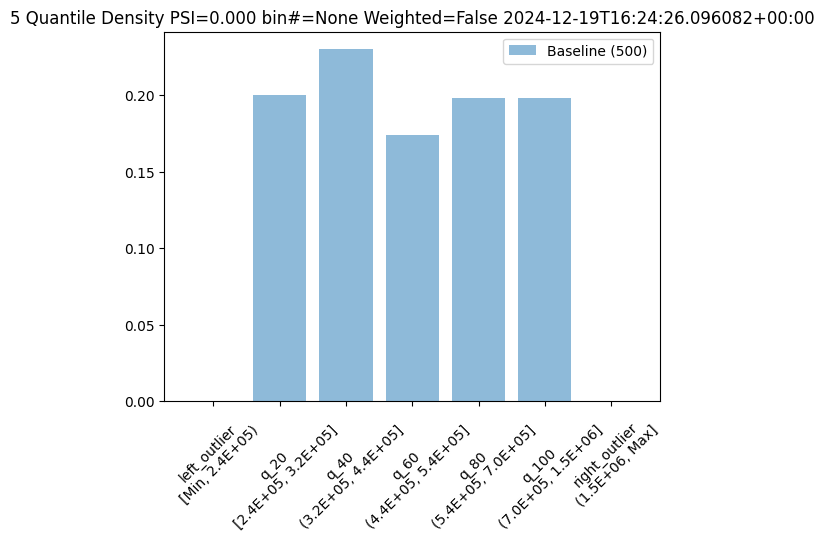

In [17]:
assay_baseline_run_from_dates.chart()

This chart is from an assay baseline generated from a set of numpy values.

baseline mean = 527349.0638399998
baseline median = 448627.8
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False


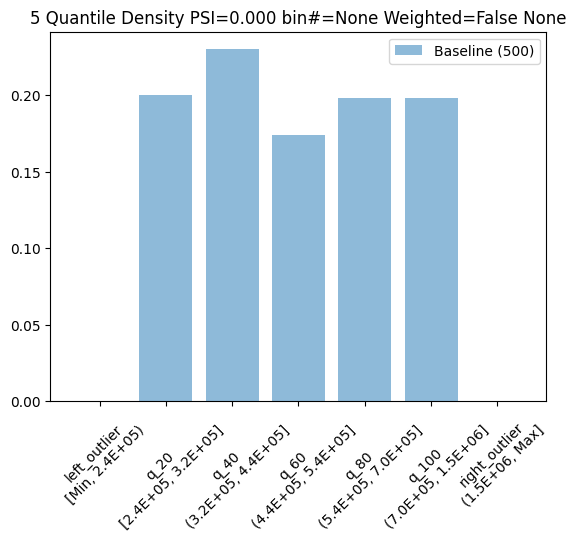

In [18]:
assay_baseline_run_from_numpy.chart()

#### Baseline DataFrame

The method [`wallaroo.assay_config.AssayBuilder.baseline_dataframe`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#AssayBuilder.baseline_dataframe) returns a DataFrame of the assay baseline generated from the provided parameters.  This includes:

* `metadata`:  The inference metadata with the model information, inference time, and other related factors.
* `in` data:  Each input field assigned with the label `in.{input field name}`.
* `out` data:  Each output field assigned with the label `out.{output field name}`

Note that for assays generated from numpy values, there is only the `out` data based on the supplied baseline data.

In the following example, the baseline DataFrame is retrieved.  

This baseline DataFrame is from an assay baseline generated from a set of inferences across a range of dates.

In [19]:
display(assay_baseline_from_dates.baseline_dataframe())

,time,metadata,input_tensor_0,input_tensor_1,input_tensor_2,input_tensor_3,input_tensor_4,input_tensor_5,input_tensor_6,input_tensor_7,input_tensor_8,input_tensor_9,input_tensor_10,input_tensor_11,input_tensor_12,input_tensor_13,input_tensor_14,input_tensor_15,input_tensor_16,input_tensor_17,output_variable_0
0,1734625526186,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': '891c2825-2a2a-41d5-9cc0-d163eba07225', 'elapsed': [2146223, 3334204], 'dropped': [], 'partition': 'engine-79dbc8986-5fbxf'}",3.0,3.00,1520.0,1884.0,3.0,0.0,0.0,3.0,8.0,1520.0,0.0,47.717602,-122.283997,1360.0,1939.0,5.0,0.0,0.0,424966.59375
1,1734625526186,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': '891c2825-2a2a-41d5-9cc0-d163eba07225', 'elapsed': [2146223, 3334204], 'dropped': [], 'partition': 'engine-79dbc8986-5fbxf'}",4.0,1.00,1750.0,68841.0,1.0,0.0,0.0,3.0,7.0,1750.0,0.0,47.444199,-122.081001,1550.0,32799.0,72.0,0.0,0.0,303002.25000
2,1734625526186,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': '891c2825-2a2a-41d5-9cc0-d163eba07225', 'elapsed': [2146223, 3334204], 'dropped': [], 'partition': 'engine-79dbc8986-5fbxf'}",3.0,2.50,1660.0,2890.0,2.0,0.0,0.0,3.0,7.0,1660.0,0.0,47.543400,-122.292999,1540.0,2890.0,14.0,0.0,0.0,544392.06250
3,1734625526186,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': '891c2825-2a2a-41d5-9cc0-d163eba07225', 'elapsed': [2146223, 3334204], 'dropped': [], 'partition': 'engine-79dbc8986-5fbxf'}",3.0,2.50,2830.0,3750.0,3.0,0.0,0.0,3.0,10.0,2830.0,0.0,47.679901,-122.385002,1780.0,5000.0,0.0,0.0,0.0,937359.62500
4,1734625526186,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': '891c2825-2a2a-41d5-9cc0-d163eba07225', 'elapsed': [2146223, 3334204], 'dropped': [], 'partition': 'engine-79dbc8986-5fbxf'}",3.0,2.25,3280.0,79279.0,1.0,0.0,0.0,3.0,10.0,3280.0,0.0,47.320702,-122.292999,1860.0,24008.0,13.0,0.0,0.0,634865.68750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1734625526186,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': '891c2825-2a2a-41d5-9cc0-d163eba07225', 'elapsed': [2146223, 3334204], 'dropped': [], 'partition': 'engine-79dbc8986-5fbxf'}",3.0,2.50,2370.0,4200.0,2.0,0.0,0.0,3.0,8.0,2370.0,0.0,47.369900,-122.018997,2370.0,4370.0,1.0,0.0,0.0,349102.75000
496,1734625526186,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': '891c2825-2a2a-41d5-9cc0-d163eba07225', 'elapsed': [2146223, 3334204], 'dropped': [], 'partition': 'engine-79dbc8986-5fbxf'}",2.0,1.75,2080.0,8112.0,1.0,1.0,4.0,4.0,8.0,1040.0,1040.0,47.713402,-122.277000,2030.0,8408.0,75.0,1.0,45.0,987157.25000
497,1734625526186,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': '891c2825-2a2a-41d5-9cc0-d163eba07225', 'elapsed': [2146223, 3334204], 'dropped': [], 'partition': 'engine-79dbc8986-5fbxf'}",4.0,2.50,2630.0,5701.0,2.0,0.0,0.0,3.0,7.0,2630.0,0.0,47.375000,-122.160004,2770.0,5939.0,4.0,0.0,0.0,368504.31250
498,1734625526186,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': '891c2825-2a2a-41d5-9c

This baseline DataFrame is from an assay baseline generated from an array of numpy values.

In [20]:
display(assay_baseline_from_numpy.baseline_dataframe())

,output_variable_0
0,424966.60
1,303002.25
2,544392.06
3,937359.60
4,634865.70
...,...
495,349102.75
496,987157.25
497,368504.30
498,924823.80


#### Baseline Stats

The method `wallaroo.assay.AssayAnalysis.baseline_stats()` returns a `pandas.core.frame.DataFrame` of the baseline stats.

The baseline stats for each assay are displayed in the examples below.

This baseline states DataFrame is from an assay baseline generated from a set of inferences across a range of dates.

In [21]:
assay_baseline_run_from_dates.baseline_stats()

,Baseline
count,500
min,236238.671875
max,1489624.25
mean,527349.061531
median,448627.8125
std,242810.711651
start,2024-12-19T16:24:26.096082+00:00
end,2024-12-19T16:25:26.198082+00:00


This baseline states DataFrame is from an assay baseline generated from an array of numpy values.

In [22]:
assay_baseline_run_from_numpy.baseline_stats()

,Baseline
count,500
min,236238.67
max,1489624.3
mean,527349.06384
median,448627.8
std,242810.71533
start,None
end,None


#### Baseline Bins

The method `wallaroo.assay.AssayAnalysis.baseline_bins` a simple dataframe to with the edge/bin data for a baseline.

These baseline bins DataFrame is from an assay baseline generated from a set of inferences across a range of dates.

In [23]:
assay_baseline_run_from_dates.baseline_bins()

,b_edges,b_edge_names,b_aggregated_values,b_aggregation
0,2.362387e+05,left_outlier,0.000,Aggregation.DENSITY
1,3.238563e+05,q_20,0.200,Aggregation.DENSITY
2,4.371780e+05,q_40,0.230,Aggregation.DENSITY
3,5.363712e+05,q_60,0.174,Aggregation.DENSITY
4,7.032827e+05,q_80,0.198,Aggregation.DENSITY
5,1.489624e+06,q_100,0.198,Aggregation.DENSITY
6,inf,right_outlier,0.000,Aggregation.DENSITY


These baseline bins DataFrame is from an assay baseline generated from an array of numpy values.

In [24]:
assay_baseline_run_from_numpy.baseline_bins()

,b_edges,b_edge_names,b_aggregated_values,b_aggregation
0,236238.67,left_outlier,0.000,Aggregation.DENSITY
1,323856.28,q_20,0.200,Aggregation.DENSITY
2,437177.97,q_40,0.230,Aggregation.DENSITY
3,536371.20,q_60,0.174,Aggregation.DENSITY
4,703282.70,q_80,0.198,Aggregation.DENSITY
5,1489624.30,q_100,0.198,Aggregation.DENSITY
6,inf,right_outlier,0.000,Aggregation.DENSITY


#### Baseline Histogram Chart

The method [`wallaroo.assay_config.AssayBuilder.baseline_histogram`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#AssayBuilder.baseline_dataframe) returns a histogram chart of the assay baseline generated from the provided parameters.

These chart is from an assay baseline generated from a set of inferences across a range of dates.

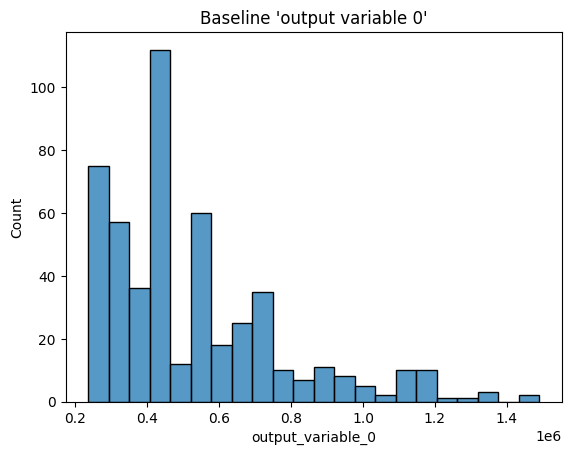

In [25]:
assay_baseline_from_dates.baseline_histogram()

#### Baseline KDE Chart

The method [`wallaroo.assay_config.AssayBuilder.baseline_kde`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#AssayBuilder.baseline_dataframe) returns a Kernel Density Estimation (KDE) chart of the assay baseline generated from the provided parameters.

These chart is from an assay baseline generated from a set of inferences across a range of dates.

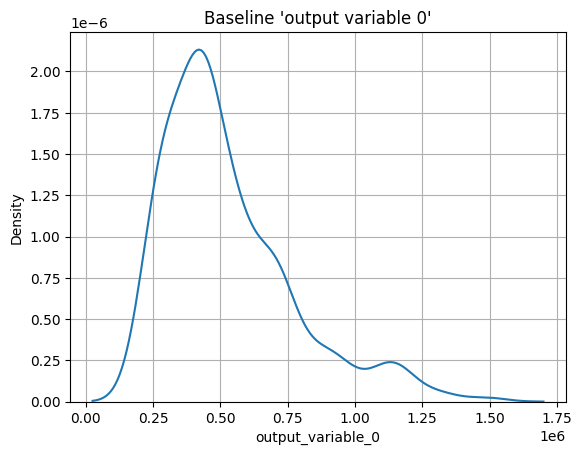

In [26]:
assay_baseline_from_dates.baseline_kde()

#### Baseline ECDF Chart

The method [`wallaroo.assay_config.AssayBuilder.baseline_ecdf`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#AssayBuilder.baseline_dataframe) returns a Empirical Cumulative Distribution Function (CDF) chart of the assay baseline generated from the provided parameters.

These chart is from an assay baseline generated from a set of inferences across a range of dates.

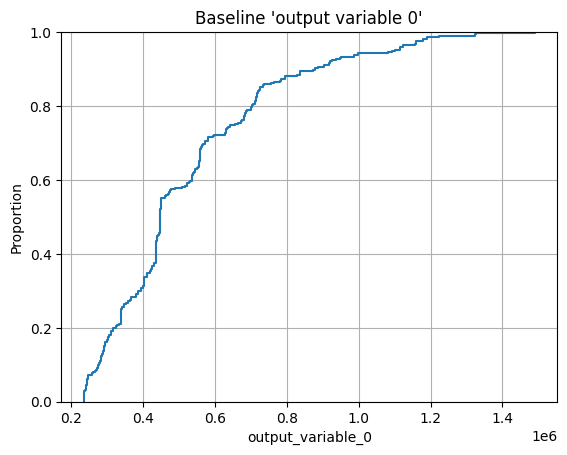

In [27]:
assay_baseline_from_dates.baseline_ecdf()

### Assay Preview

Now that the baseline is defined, we look at different configuration options and view how the assay baseline and results changes.  Once we determine what gives us the best method of determining model drift, we can create the assay.

#### Analysis List Chart Scores

Analysis List scores show the assay scores for each assay result interval in one chart.  Values that are outside of the alert threshold are colored red, while scores within the alert threshold are green.

Assay chart scores are displayed with the method `wallaroo.assay.AssayAnalysisList.chart_scores`, with ability to display an optional title with the chart.  This takes the following parameters:

| Parameter | Type | Description |
|---|---|---|
| **title** | *String* (*Optional*) | The title to assign the chart. |
| **nth_x_tick** | *Integer* (*Optional*) (*Default: 4*) | The density of the x ticks.  |
| **start** | *DateTime* (*Optional*) | The start time of the chart.  If `start` is set, the parameter `end` **must** be set. |
| **end** | *DateTime* (*Optional*) | The end time of the chart.  If `end` is set, the parameter `start` **must** be set. |

The following example shows retrieving the assay results and displaying the chart scores.  From our example, we have two windows - the first should be green, and the second is red showing that values were outside the alert threshold.

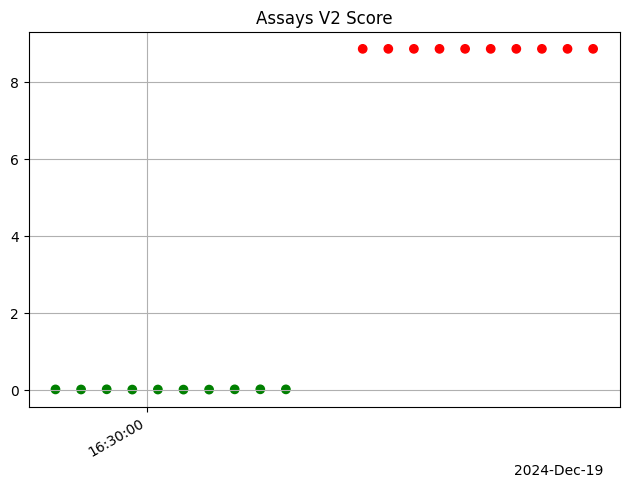

In [28]:
assay_baseline = wl.build_assay(assay_name=assay_name, 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# Set the assay parameters

# The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now())

# Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)


# build the assay configuration
assay_config = assay_baseline.build()

# perform an interactive run and collect inference data
assay_results = assay_config.interactive_run()

# show the analyses chart
assay_results.chart_scores()

The following chart uses the `nth_x_tick` setting to space out the x-axis labels further.

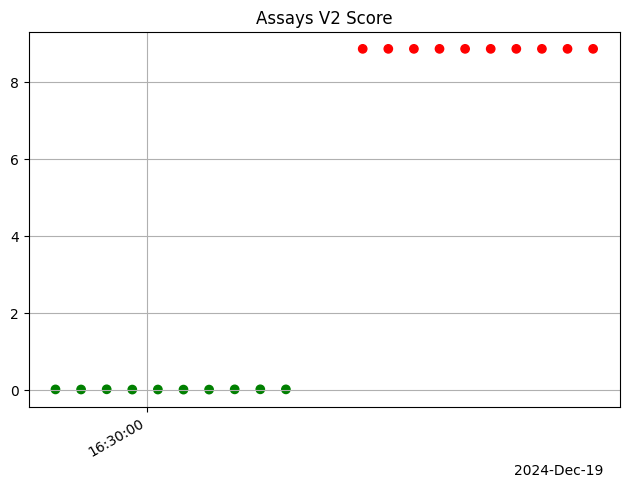

In [29]:
# set different nth_x_tick
assay_results.chart_scores(nth_x_tick=10)

#### Analysis Chart

The method `wallaroo.assay.AssayAnalysis.chart()` displays a comparison between the baseline and an interval of inference data.

This is compared to the [Chart Scores](#analysis-list-chart-scores), which is a **list** of all of the inference data split into intervals, while the **Analysis Chart** shows the breakdown of one set of inference data against the baseline.

Score from the [Analysis List Chart Scores](#analysis-list-chart-scores) and each element from the [Analysis List DataFrame](#analysis-list-dataframe) generates 

The following fields are included.

| Field | Type | Description |
|---|---|---|
| **baseline mean** | **Float** | The mean of the baseline values. |
| **window mean** | **Float** | The mean of the window values. |
| **baseline median** | **Float** | The median of the baseline values. |
| **window median** | **Float** | The median of the window values. |
| **bin_mode** | **String** | The binning mode used for the assay. |
| **aggregation** | **String** | The aggregation mode used for the assay. |
| **metric** | **String** | The metric mode used for the assay. |
| **weighted** | **Bool** | Whether the bins were manually weighted. |
| **score** | **Float** | The score from the assay window. |
| **scores** | **List(Float)** | The score from each assay window bin. |
| **index** | **Integer/None** | The window index.  Interactive assay runs are `None`. |

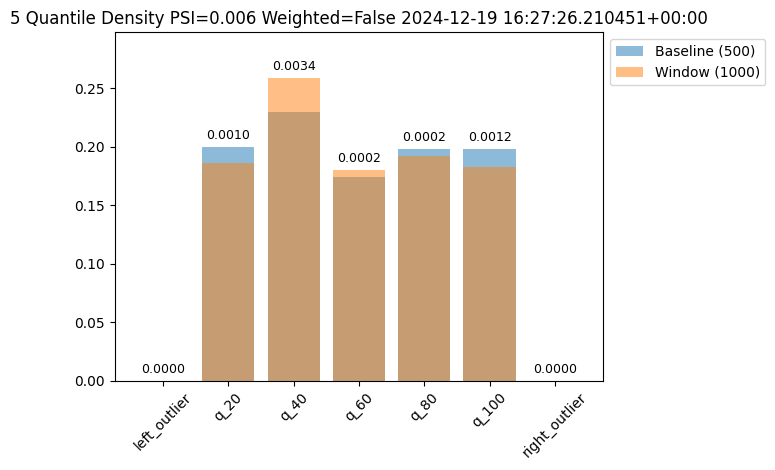

In [30]:
# Create the assay baseline
assay_baseline = wl.build_assay(assay_name="assays from date baseline sample", 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# Set the assay parameters

# The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now())

# Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

# build the assay configuration
assay_config = assay_baseline.build()

# perform an interactive run and collect inference data
assay_results = assay_config.interactive_run()

# display one of the analysis from the total results
assay_results[0].chart()

#### Analysis List DataFrame

`wallaroo.assay.AssayAnalysisList.to_dataframe()` returns a DataFrame showing the assay results for each window aka individual analysis.  This DataFrame contains the following fields:

| Field | Type | Description |
|---|---|---|
| **assay_id** | *String/None* | The assay id in UUID format.  Only provided from uploaded and executed assays. |
| **name** | *String/None* | The name of the assay.  Only provided from uploaded and executed assays. |
| **iopath** | *String/None* | The iopath of the assay.  Only provided from uploaded and executed assays. |
| **score** | *Float* | The assay score. |
| **start** | *DateTime* | The DateTime start of the assay window.
| **min** | *Float* | The minimum value in the assay window.
| **max**  | *Float* | The maximum value in the assay window.
| **mean** | *Float* | The mean value in the assay window.
| **median** | *Float* | The median value in the assay window.
| **std** | *Float* | The standard deviation value in the assay window.
| **warning_threshold** | *Float/None* | The warning threshold of the assay window.
| **alert_threshold** | *Float/None* | The alert threshold of the assay window.
| **status** | *String* | The assay window status.  Values are:  <ul><li>`OK`: The score is within accepted thresholds.</li><li>`Warning`: The score has triggered the `warning_threshold` if exists, but not the `alert_threshold`.</li><li>`Alert`: The score has triggered the the `alert_threshold`.</li></ul> |

For this example, the assay analysis list DataFrame is listed.  

From this tutorial, we should have 2 windows of dta to look at, each one minute apart.  The first window should show `status: OK`, with the second window with the very large house prices will show `status: alert`

In [31]:
# Create the assay baseline
assay_baseline = wl.build_assay(assay_name=assay_name, 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# Set the assay parameters

# The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now())

# Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

# build the assay configuration
assay_config = assay_baseline.build()

# perform an interactive run and collect inference data
assay_results = assay_config.interactive_run()

# display the dataframe from the analyses
assay_results.to_dataframe()

,id,assay_id,assay_name,iopath,pipeline_id,pipeline_name,workspace_id,workspace_name,score,start,min,max,mean,median,std,warning_threshold,alert_threshold,status
0,0,cb6e894c-40cc-4f2e-8e9e-4f0ba188d2f2,assay-demonstration-tutorial assay,out.variable.0,1,assay-demonstration-tutorial,9,assay-demonstration-tutorial-2,0.006029,2024-12-19 16:26:26.210451+00:00,2.362387e+05,1489624.250,5.174628e+05,4.486278e+05,228315.343750,None,0.25,Ok
1,0,cb6e894c-40cc-4f2e-8e9e-4f0ba188d2f2,assay-demonstration-tutorial assay,out.variable.0,1,assay-demonstration-tutorial,9,assay-demonstration-tutorial-2,0.004165,2024-12-19 16:27:26.210451+00:00,2.362387e+05,1364149.875,5.176297e+05,4.489289e+05,223850.687500,None,0.25,Ok
2,0,cb6e894c-40cc-4f2e-8e9e-4f0ba188d2f2,assay-demonstration-tutorial assay,out.variable.0,1,assay-demonstration-tutorial,9,assay-demonstration-tutorial-2,0.008836,2024-12-19 16:28:26.210451+00:00,2.362387e+05,1489624.250,5.202844e+05,4.486278e+05,237580.015625,None,0.25,Ok
3,0,cb6e894c-40cc-4f2e-8e9e-4f0ba188d2f2,assay-demonstration-tutorial assay,out.variable.0,1,assay-demonstration-tutorial,9,assay-demonstration-tutorial-2,0.001920,2024-12-19 16:29:26.210451+00:00,2.362387e+05,1489624.250,5.255399e+05,4.486278e+05,243668.000000,None,0.25,Ok
4,0,cb6e894c-40cc-4f2e-8e9e-4f0ba188d2f2,assay-demonstration-tutorial assay,out.variable.0,1,assay-demonstration-tutorial,9,assay-demonstration-tutorial-2,0.003151,2024-12-19 16:30:26.210451+00:00,2.362387e+05,1489624.250,5.106707e+05,4.486278e+05,221293.593750,None,0.25,Ok
5,0,cb6e894c-40cc-4f2e-8e9e-4f0ba188d2f2,assay-demonstration-tutorial assay,out.variable.0,1,assay-demonstration-tutorial,9,assay-demonstration-tutorial-2,0.001399,2024-12-19 16:31:26.210451+00:00,2.362387e+05,1489624.250,5.164491e+05,4.486278e+05,229535.453125,None,0.25,Ok
6,0,cb6e894c-40cc-4f2e-8e9e-4f0ba188d2f2,assay-demonstration-tutorial assay,out.variable.0,1,assay-demonstration-tutorial,9,assay-demonstration-tutorial-2,0.001459,2024-12-19 16:32:26.210451+00:00,2.362387e+05,1489624.250,5.242250e+05,4.508677e+05,233475.187500,None,0.25,Ok
7,0,cb6e894c-40cc-4f2e-8e9e-4f0ba188d2f2,assay-demonstration-tutorial assay,out.variable.0,1,assay-demonstration-tutorial,9,assay-demonstration-tutorial-2,0.007347,2024-12-19 16:33:26.210451+00:00,2.362387e+05,1489624.250,5.174510e+05,4.486278e+05,227477.843750,None,0.25,Ok
8,0,cb6e894c-40cc-4f2e-8e9e-4f0ba188d2f2,assay-demonstration-tutorial assay,out.variable.0,1,assay-demonstration-tutorial,9,assay-demonstration-tutorial-2,0.008707,2024-12-19 16:34:26.210451+00:00,2.362387e+05,1489624.250,5.073022e+05,4.486278e+05,230616.375000,None,0.25,Ok
9,0,cb6e894c-40cc-4f2e-8e9e-4f0ba188d2f2,assay-demonstration-tutorial assay,out.variable.0,1,assay-demonstration-tutorial,9,assay-demonstration-tutorial-2,0.007234,2024-12-19 16:35:26.210451+00:00,2.362387e+05,1489624.250,5.087417e+05,4.486278e+05,230061.750000,None,0.25,Ok


#### Analysis List Full DataFrame

`wallaroo.assay.AssayAnalysisList.to_full_dataframe()` returns a DataFrame showing all values, including the inputs and outputs from the assay results for each window aka individual analysis.  This DataFrame contains the following fields:


	pipeline_id	warning_threshold	bin_index	created_at


| Field | Type | Description |
|---|---|---|
| **window_start** | *DateTime* | The date and time when the window period began. |
| **analyzed_at** | *DateTime* | The date and time when the assay analysis was performed. |
| **elapsed_millis** | *Integer* | How long the analysis took to perform in milliseconds. |
| **baseline_summary_count** | *Integer* | The number of data elements from the baseline. |
| **baseline_summary_min** | *Float* | The minimum value from the baseline summary. |
| **baseline_summary_max** | *Float* | The maximum value from the baseline summary. |
| **baseline_summary_mean** | *Float* | The mean value of the baseline summary. |
| **baseline_summary_median** | *Float* | The median value of the baseline summary. |
| **baseline_summary_std** | *Float* | The standard deviation value of the baseline summary. |
| **baseline_summary_edges_{0...n}** | *Float* | The baseline summary edges for each baseline edge from 0 to number of edges. |
| **summarizer_type** | *String* | The type of summarizer used for the baseline.  See [`wallaroo.assay_config` for other summarizer types](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/). |
| **summarizer_bin_weights** | *List / None* | If baseline bin weights were provided, the list of those weights.  Otherwise, `None`. |
| **summarizer_provided_edges** | *List / None* | If baseline bin edges were provided, the list of those edges.  Otherwise, `None`. |
| **status** | *String* | The assay window status.  Values are:  <ul><li>`OK`: The score is within accepted thresholds.</li><li>`Warning`: The score has triggered the `warning_threshold` if exists, but not the `alert_threshold`.</li><li>`Alert`: The score has triggered the the `alert_threshold`.</li></ul> |
| **id** | *Integer/None* | The id for the window aka analysis.  Only provided from uploaded and executed assays. |
| **assay_id** | *String/None* | The assay id in UUID format.  Only provided from uploaded and executed assays. |
| **pipeline_id** | *Integer/None* | The pipeline id.  Only provided from uploaded and executed assays. |
| **warning_threshold** | *Float* | The warning threshold set for the assay. |
| **warning_threshold** | *Float* | The warning threshold set for the assay.
| **bin_index** | *Integer/None* | The bin index for the window aka analysis.|
| **created_at** | *Datetime/None* | The date and time the window aka analysis was generated.  Only provided from uploaded and executed assays. |

For this example, full DataFrame from an assay preview is generated.

From this tutorial, we should have 2 windows of dta to look at, each one minute apart.  The first window should show `status: OK`, with the second window with the very large house prices will show `status: alert`

In [32]:
# Create the assay baseline
assay_baseline = wl.build_assay(assay_name=assay_name, 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# Set the assay parameters

# The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now())

# Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

# build the assay configuration
assay_config = assay_baseline.build()

# perform an interactive run and collect inference data
assay_results = assay_config.interactive_run()

# display the full dataframe from the analyses
assay_results.to_full_dataframe()

,id,assay_id,window_start,analyzed_at,elapsed_millis,pipeline_id,workspace_id,workspace_name,baseline_summary_aggregated_values_0,baseline_summary_aggregated_values_1,baseline_summary_aggregated_values_2,baseline_summary_aggregated_values_3,baseline_summary_aggregated_values_4,baseline_summary_aggregated_values_5,baseline_summary_aggregated_values_6,baseline_summary_aggregation,baseline_summary_bins_edges_0,baseline_summary_bins_edges_1,baseline_summary_bins_edges_2,baseline_summary_bins_edges_3,baseline_summary_bins_edges_4,baseline_summary_bins_edges_5,baseline_summary_bins_edges_6,baseline_summary_bins_labels_0,baseline_summary_bins_labels_1,baseline_summary_bins_labels_2,baseline_summary_bins_labels_3,baseline_summary_bins_labels_4,baseline_summary_bins_labels_5,baseline_summary_bins_labels_6,baseline_summary_bins_mode_Quantile,baseline_summary_name,baseline_summary_statistics_count,baseline_summary_statistics_max,baseline_summary_statistics_mean,baseline_summary_statistics_median,baseline_summary_statistics_min,baseline_summary_statistics_std,baseline_summary_end,baseline_summary_start,window_summary_aggregated_values_0,window_summary_aggregated_values_1,window_summary_aggregated_values_2,window_summary_aggregated_values_3,window_summary_aggregated_values_4,window_summary_aggregated_values_5,window_summary_aggregated_values_6,window_summary_bins_edges_0,window_summary_bins_edges_1,window_summary_bins_edges_2,window_summary_bins_edges_3,window_summary_bins_edges_4,window_summary_bins_edges_5,window_summary_bins_edges_6,window_summary_bins_labels_0,window_summary_bins_labels_1,window_summary_bins_labels_2,window_summary_bins_labels_3,window_summary_bins_labels_4,window_summary_bins_labels_5,window_summary_bins_labels_6,window_summary_bins_mode_Quantile,window_summary_statistics_count,window_summary_statistics_max,window_summary_statistics_mean,window_summary_statistics_median,window_summary_statistics_min,window_summary_statistics_std,window_summary_end,window_summary_start,warning_threshold,alert_threshold,bin_index,summarizer_UnivariateContinuous_aggregation,summarizer_UnivariateContinuous_bin_mode_Quantile,summarizer_UnivariateContinuous_metric,summarizer_UnivariateContinuous_bin_weights,status,created_at,score,scores_0,scores_1,scores_2,scores_3,scores_4,scores_5,scores_6
0,0,7a216b5c-93b5-4958-a9ea-b7a0ef39a0c9,2024-12-19T16:26:26.210451+00:00,2024-12-19 17:00:16.511113+00:00,88,1,9,assay-demonstration-tutorial-2,0.0,0.2,0.23,0.174,0.198,0.198,0.0,Density,236238.671875,323856.28125,437177.96875,536371.1875,703282.6875,1489624.25,INFINITY,left_outlier,q_20,q_40,q_60,q_80,q_100,right_outlier,5,out.variable.0,500,1489624.25,527349.061531,448627.8125,236238.671875,242810.711651,2024-12-19T16:25:26.198082+00:00,2024-12-19T16:24:26.096082+00:00,0.0,0.186,0.259,0.180,0.192,0.183,0.0,236238.671875,323856.28125,437177.96875,536371.1875,703282.6875,1489624.25,INFINITY,left_outlier,q_20,q_40,q_60,q_80,q_100,right_outlier,5,1000,1489624.250,5.174628e+05,4.486278e+05,2.362387e+05,228315.343750,2024-12-19T16:27:26.210451+00:00,2024-12-19T16:26:26.210451+00:00,None,0.25,None,Density,5,PSI,None,Ok,None,0.006029,0.0,0.001016,0.003444,0.000203,0.000185,0.001182,0.000000
1,0,7a216b5c-93b5-4958-a9ea-b7a0ef39a0c9,2024-12-19T16:27:26.210451+00:00,2024-12-19 17:00:16.429451+00:00,82,1,9,assay-demonstration-tutorial-2,0.0,0.2,0.23,0.174,0.198,0.198,0.0,Density,236238.671875,323856.28125,437177.96875,536371.1875,703282.6875,1489624.25,INFINITY,left_outlier,q_20,q_40,q_60,q_80,q_100,right_outlier,5,out.variable.0,500,1489624.25,527349.061531,448627.8125,236238.671875,242810.711651,2024-12-19T16:25:26.198082+00:00,2024-12-19T16:24:26.096082+00:00,0.0,0.212,0.212,0.187,0.185,0.204,0.0,236238.671875,323856.28125,437177.96875,536371.1875,703282.6875,1489624.25,INFINITY,left_outlier,q_20,q_40,q_60,q_80,q_100,right_outlier,5,1000,1364149.875,5.176297e+05,4.489289e+05,2.362387e+05,223850.687500,2024-12-19T16:28:26.210451+00:00,2024-12-19T16:27:26.2104

#### Analysis Compare Basic Stats

The method `wallaroo.assay.AssayAnalysis.compare_basic_stats` returns a DataFrame comparing one set of inference data against the baseline.

This is compared to the [Analysis List DataFrame](#analysis-list-dataframe), which is a **list** of all of the inference data split into intervals, while the **Analysis Compare Basic Stats** shows the breakdown of one set of inference data against the baseline.

In [33]:
# Create the assay baseline
assay_baseline = wl.build_assay(assay_name=assay_name, 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# Set the assay parameters

# The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now())

# Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

# build the assay configuration
assay_config = assay_baseline.build()

# perform an interactive run and collect inference data
assay_results = assay_config.interactive_run()

# display one analysis against the baseline
assay_results[0].compare_basic_stats()

,Baseline,Window,diff,pct_diff
count,500.0,1000.0,500.0,100.0
max,1489624.25,1489624.25,0.0,0.0
mean,527349.061531,517462.795984,-9886.265547,-1.87471
median,448627.8125,448627.8125,0.0,0.0
min,236238.671875,236238.671875,0.0,0.0
std,242810.711651,228315.34375,-14495.367901,-5.969822
start,2024-12-19T16:24:26.096082+00:00,2024-12-19T16:26:26.210451+00:00,NaN,NaN
end,2024-12-19T16:25:26.198082+00:00,2024-12-19T16:27:26.210451+00:00,NaN,NaN


#### Configure Assays

Before creating the assay, **configure** the assay and continue to preview it until the best method for detecting drift is set.  The following options are available.

##### Inference Interval and Inference Width

The inference interval aka window interval sets how often to run the assay analysis.  This is set from the [`wallaroo.assay_config.AssayBuilder.window_builder.add_interval`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#WindowBuilder.add_interval) method to collect data expressed in time units:  "hours=24", "minutes=1", etc.

For example, with an interval of 1 minute, the assay collects data every minute.  Within an hour, 60 intervals of data is collected.

We can adjust the interval and see how the assays change based on how **frequently** they are run.

The width sets the time period from the [`wallaroo.assay_config.AssayBuilder.window_builder.add_width`](/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#WindowBuilder.add_width) method to collect data expressed in time units:  "hours=24", "minutes=1", etc.

For example, an interval of 1 minute and a width of 1 minute collects 1 minutes worth of data every minute.  An interval of 1 minute with a width of 5 minutes collects 5 minute of inference data every minute.

By default, the interval and width is **24 hours**.

For this example, we'll adjust the width and interval from 1 minute to 5 minutes and see how the number of analyses and their score changes.

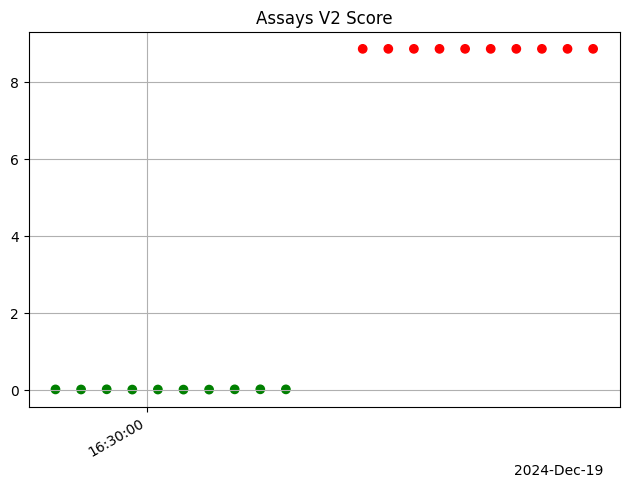

In [34]:
# Create the assay baseline
assay_baseline = wl.build_assay(assay_name=assay_name, 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# Set the assay parameters

# The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now())

# Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)


# build the assay configuration
assay_config = assay_baseline.build()

# perform an interactive run and collect inference data
assay_results = assay_config.interactive_run()

# show the analyses chart
assay_results.chart_scores()

In [35]:
wl.get_current_workspace()

{'name': 'assay-demonstration-tutorial-2', 'id': 9, 'archived': False, 'created_by': '0c74dc8a-39cb-4b1e-8ba8-4013193b859b', 'created_at': '2024-12-19T16:23:09.211681+00:00', 'models': [{'name': 'house-price-estimator', 'versions': 1, 'owner_id': '""', 'last_update_time': datetime.datetime(2024, 12, 19, 16, 23, 9, 888676, tzinfo=tzutc()), 'created_at': datetime.datetime(2024, 12, 19, 16, 23, 9, 888676, tzinfo=tzutc())}], 'pipelines': [{'name': 'assay-demonstration-tutorial', 'create_time': datetime.datetime(2024, 12, 19, 16, 23, 10, 22182, tzinfo=tzutc()), 'definition': '[]'}]}

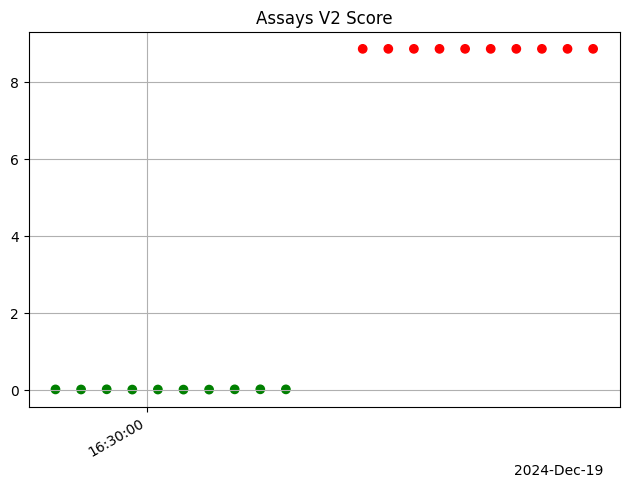

In [36]:
# Create the assay baseline
assay_baseline = wl.build_assay(assay_name=assay_name, 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# Set the assay parameters

# The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now())

# Set the interval and window to five minutes each, set the start date for gathering inference results
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

# build the assay configuration
assay_config = assay_baseline.build()

# perform an interactive run and collect inference data
assay_results = assay_config.interactive_run()

# show the analyses chart
assay_results.chart_scores()

##### Add Run Until and Add Inference Start

For previewing assays, setting [`wallaroo.assay_config.AssayBuilder.add_run_until`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#AssayBuilder.add_run_until) sets the **end date and time** for collecting inference data.  When an assay is uploaded, this setting is no longer valid - assays run at the [Inference Interval](#inference-interval-and-inference-width) until the [assay is paused](#pause-and-resume-assay).

Setting the [`wallaroo.assay_config.WindowBuilder.add_start`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#WindowBuilder.add_start) sets the **start date and time** to collect inference data.   When an assay is uploaded, this setting **is included**, and assay results will be displayed starting from that start date at the [Inference Interval](#inference-interval-and-inference-width) until the [assay is paused](#pause-and-resume-assay).  By default, `add_start` begins 24 hours after the assay is uploaded unless set in the assay configuration manually.

For the following example, the `add_run_until` setting is set to `datetime.datetime.now()` to collect all inference data from `assay_window_start` up until now, and the second example limits that example to only two minutes of data.

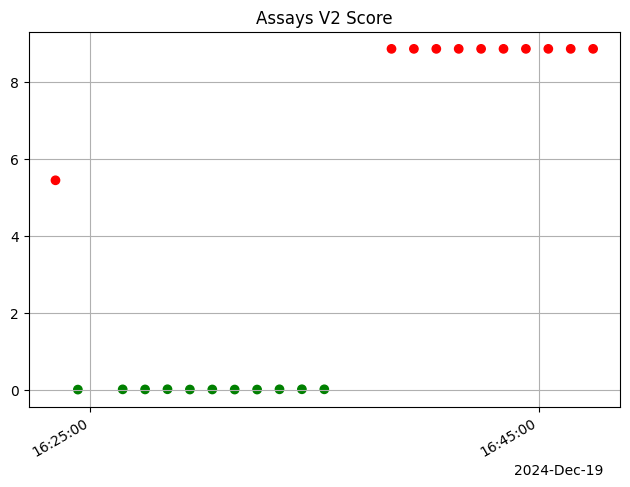

In [37]:
# Create the assay baseline
assay_baseline = wl.build_assay(assay_name=assay_name, 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# Set the assay parameters

# The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now())

# Set the interval and window to one minute each, set the start date for gathering inference results, minus 2 minutes for the period to start gathering analyses
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start+datetime.timedelta(seconds=-120))


# build the assay configuration
assay_config = assay_baseline.build()

# perform an interactive run and collect inference data
assay_results = assay_config.interactive_run()

# show the analyses chart
assay_results.chart_scores()

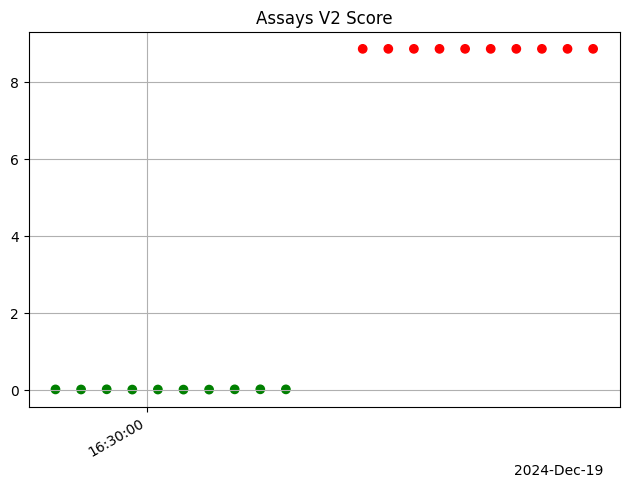

In [43]:
assay_baseline = wl.build_assay(assay_name=assay_name, 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# Set the assay parameters

# The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now()+datetime.timedelta(seconds=120))

# Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)


# build the assay configuration
assay_config = assay_baseline.build()

# perform an interactive run and collect inference data
assay_results = assay_config.interactive_run()

# show the analyses chart
assay_results.chart_scores()

##### Score Metric

The `score` is a distance between the baseline and the analysis window.  The larger the score, the greater the difference between the baseline and the analysis window.  The following methods are provided determining the score:

* `PSI` (*Default*) - Population Stability Index (PSI).
* `MAXDIFF`: Maximum difference between corresponding bins.
* `SUMDIFF`: Mum of differences between corresponding bins.

The metric type used is updated with the [`wallaroo.assay_config.AssayBuilder.add_metric(metric: wallaroo.assay_config.Metric)`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#UnivariateContinousSummarizerBuilder.add_metric) method.

The following three charts use each of the metrics.  Note how the scores change based on the score type used.

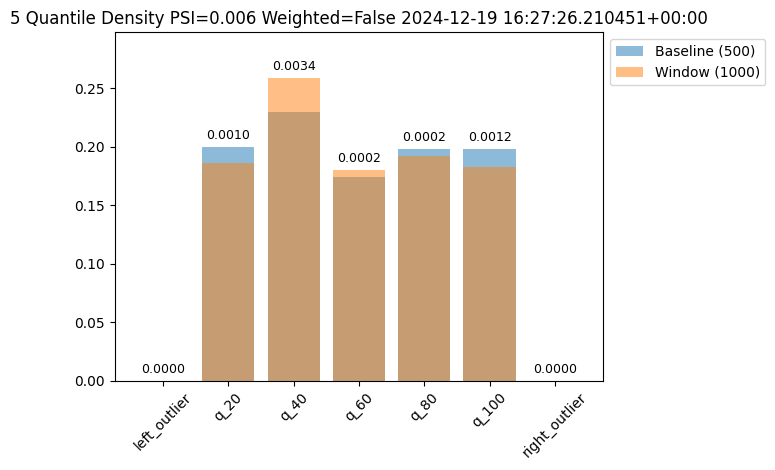

In [44]:
# Create the assay baseline
assay_baseline = wl.build_assay(assay_name=assay_name, 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# Set the assay parameters

# The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now())

# Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

# set metric PSI mode
assay_baseline.summarizer_builder.add_metric(wallaroo.assay_config.Metric.PSI)


# build the assay configuration
assay_config = assay_baseline.build()

# perform an interactive run and collect inference data
assay_results = assay_config.interactive_run()

# display one analysis from the results
assay_results[0].chart()

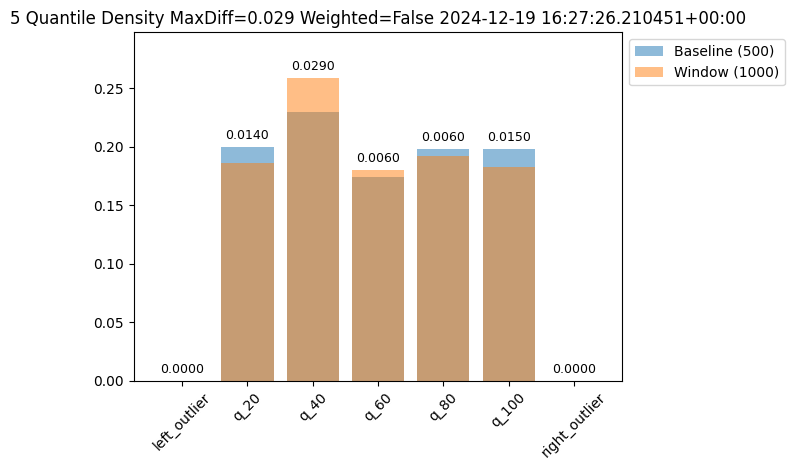

In [45]:
# Create the assay baseline
assay_baseline = wl.build_assay(assay_name=assay_name, 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# Set the assay parameters

# The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now())

# Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

# set metric MAXDIFF mode
assay_baseline.summarizer_builder.add_metric(wallaroo.assay_config.Metric.MAXDIFF)

# build the assay configuration
assay_config = assay_baseline.build()

# perform an interactive run and collect inference data
assay_results = assay_config.interactive_run()

# display one analysis from the results
assay_results[0].chart()

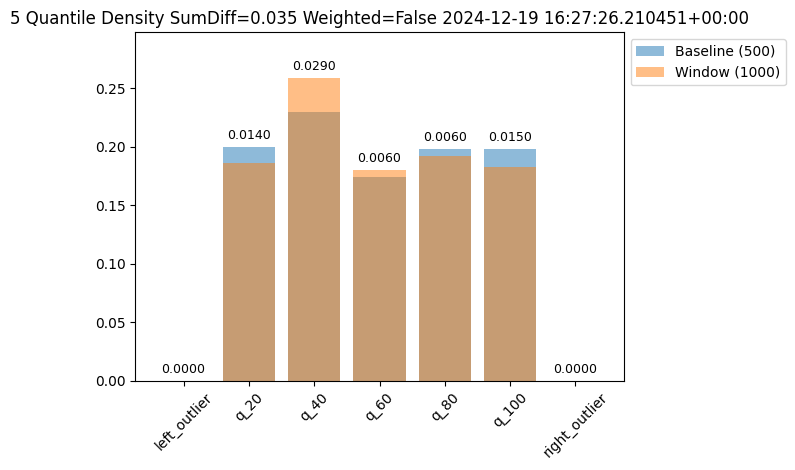

In [46]:
# Create the assay baseline
assay_baseline = wl.build_assay(assay_name=assay_name, 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# Set the assay parameters

# The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now())

# Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

# set metric SUMDIFF mode
assay_baseline.summarizer_builder.add_metric(wallaroo.assay_config.Metric.SUMDIFF)

# build the assay configuration
assay_config = assay_baseline.build()

# perform an interactive run and collect inference data
assay_results = assay_config.interactive_run()

# display one analysis from the results
assay_results[0].chart()

##### Alert Threshold

Assay alert thresholds are modified with the [`wallaroo.assay_config.AssayBuilder.add_alert_threshold(alert_threshold: float)`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/) method.  By default alert thresholds are `0.1`.

The following example updates the alert threshold to `0.5`.

In [47]:
# Create the assay baseline
assay_baseline = wl.build_assay(assay_name=assay_name, 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# Set the assay parameters

# The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now())

# Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

# set the alert threshold
assay_baseline.add_alert_threshold(0.5)

# build the assay configuration
assay_config = assay_baseline.build()

# perform an interactive run and collect inference data
assay_results = assay_config.interactive_run()

# show the analyses with the alert threshold
assay_results.to_dataframe()

,id,assay_id,assay_name,iopath,pipeline_id,pipeline_name,workspace_id,workspace_name,score,start,min,max,mean,median,std,warning_threshold,alert_threshold,status
0,0,882a80b7-5bd9-4349-a899-1d954df4d611,assay-demonstration-tutorial assay,out.variable.0,1,assay-demonstration-tutorial,9,assay-demonstration-tutorial-2,0.006029,2024-12-19 16:26:26.210451+00:00,2.362387e+05,1489624.250,5.174628e+05,4.486278e+05,228315.343750,None,0.5,Ok
1,0,882a80b7-5bd9-4349-a899-1d954df4d611,assay-demonstration-tutorial assay,out.variable.0,1,assay-demonstration-tutorial,9,assay-demonstration-tutorial-2,0.004165,2024-12-19 16:27:26.210451+00:00,2.362387e+05,1364149.875,5.176297e+05,4.489289e+05,223850.687500,None,0.5,Ok
2,0,882a80b7-5bd9-4349-a899-1d954df4d611,assay-demonstration-tutorial assay,out.variable.0,1,assay-demonstration-tutorial,9,assay-demonstration-tutorial-2,0.008836,2024-12-19 16:28:26.210451+00:00,2.362387e+05,1489624.250,5.202844e+05,4.486278e+05,237580.015625,None,0.5,Ok
3,0,882a80b7-5bd9-4349-a899-1d954df4d611,assay-demonstration-tutorial assay,out.variable.0,1,assay-demonstration-tutorial,9,assay-demonstration-tutorial-2,0.001920,2024-12-19 16:29:26.210451+00:00,2.362387e+05,1489624.250,5.255399e+05,4.486278e+05,243668.000000,None,0.5,Ok
4,0,882a80b7-5bd9-4349-a899-1d954df4d611,assay-demonstration-tutorial assay,out.variable.0,1,assay-demonstration-tutorial,9,assay-demonstration-tutorial-2,0.003151,2024-12-19 16:30:26.210451+00:00,2.362387e+05,1489624.250,5.106707e+05,4.486278e+05,221293.593750,None,0.5,Ok
5,0,882a80b7-5bd9-4349-a899-1d954df4d611,assay-demonstration-tutorial assay,out.variable.0,1,assay-demonstration-tutorial,9,assay-demonstration-tutorial-2,0.001399,2024-12-19 16:31:26.210451+00:00,2.362387e+05,1489624.250,5.164491e+05,4.486278e+05,229535.453125,None,0.5,Ok
6,0,882a80b7-5bd9-4349-a899-1d954df4d611,assay-demonstration-tutorial assay,out.variable.0,1,assay-demonstration-tutorial,9,assay-demonstration-tutorial-2,0.001459,2024-12-19 16:32:26.210451+00:00,2.362387e+05,1489624.250,5.242250e+05,4.508677e+05,233475.187500,None,0.5,Ok
7,0,882a80b7-5bd9-4349-a899-1d954df4d611,assay-demonstration-tutorial assay,out.variable.0,1,assay-demonstration-tutorial,9,assay-demonstration-tutorial-2,0.007347,2024-12-19 16:33:26.210451+00:00,2.362387e+05,1489624.250,5.174510e+05,4.486278e+05,227477.843750,None,0.5,Ok
8,0,882a80b7-5bd9-4349-a899-1d954df4d611,assay-demonstration-tutorial assay,out.variable.0,1,assay-demonstration-tutorial,9,assay-demonstration-tutorial-2,0.008707,2024-12-19 16:34:26.210451+00:00,2.362387e+05,1489624.250,5.073022e+05,4.486278e+05,230616.375000,None,0.5,Ok
9,0,882a80b7-5bd9-4349-a899-1d954df4d611,assay-demonstration-tutorial assay,out.variable.0,1,assay-demonstration-tutorial,9,assay-demonstration-tutorial-2,0.007234,2024-12-19 16:35:26.210451+00:00,2.362387e+05,1489624.250,5.087417e+05,4.486278e+05,230061.750000,None,0.5,Ok


##### Number of Bins

Number of bins sets how the baseline data is partitioned.  The total number of bins includes the set number plus the left_outlier and the right_outlier, so the total number of bins will be the total set + 2.

The number of bins is set with the [`wallaroo.assay_config.UnivariateContinousSummarizerBuilder.add_num_bins(num_bins: int)`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#UnivariateContinousSummarizerBuilder.add_num_bins) method.

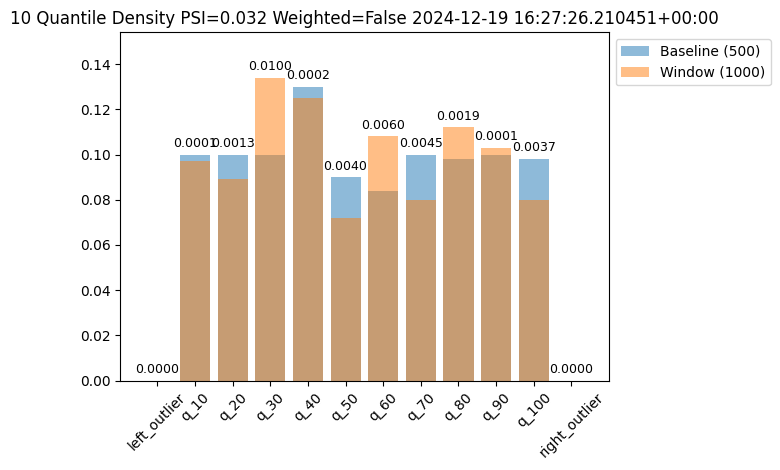

In [48]:
# Create the assay baseline
assay_baseline = wl.build_assay(assay_name=assay_name, 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# Set the assay parameters

# The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now())

# Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

# update number of bins here
assay_baseline.summarizer_builder.add_num_bins(10)

# build the assay configuration
assay_config = assay_baseline.build()

# perform an interactive run and collect inference data
assay_results = assay_config.interactive_run()

# show one analysis with the updated bins
assay_results[0].chart()

##### Binning Mode

Binning Mode defines how the bins are separated.  Binning modes are modified through the `wallaroo.assay_config.UnivariateContinousSummarizerBuilder.add_bin_mode(bin_mode: bin_mode: wallaroo.assay_config.BinMode, edges: Optional[List[float]] = None)`.

Available `bin_mode` values from `wallaroo.assay_config.Binmode` are the following:

* `QUANTILE` (*Default*): Based on percentages. If `num_bins` is 5 then quintiles so bins are created at the 20%, 40%, 60%, 80% and 100% points.
* `EQUAL`: Evenly spaced bins where each bin is set with the formula `min - max / num_bins`
* `PROVIDED`: The user provides the edge points for the bins.

If `PROVIDED` is supplied, then a List of float values must be provided for the `edges` parameter that matches the number of bins.

The following examples are used to show how each of the binning modes effects the bins.

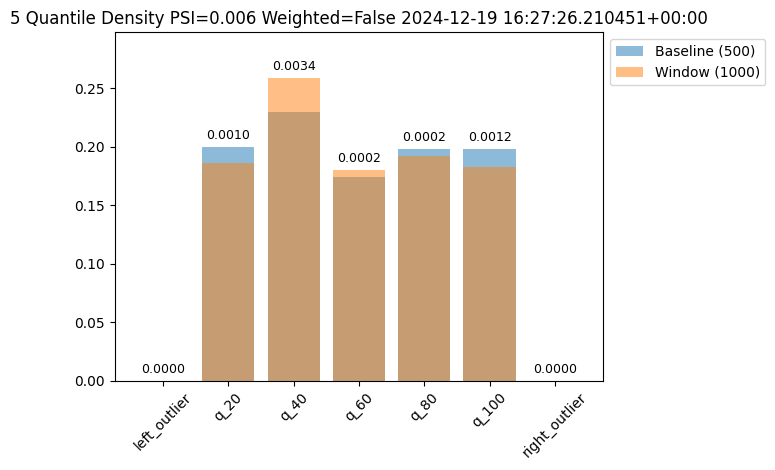

In [49]:
# Create the assay baseline
assay_baseline = wl.build_assay(assay_name=assay_name, 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# Set the assay parameters

# The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now())

# Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

# update binning mode here
assay_baseline.summarizer_builder.add_bin_mode(wallaroo.assay_config.BinMode.QUANTILE)

# build the assay configuration
assay_config = assay_baseline.build()

# perform an interactive run and collect inference data
assay_results = assay_config.interactive_run()

# show one analysis with the updated bins
assay_results[0].chart()

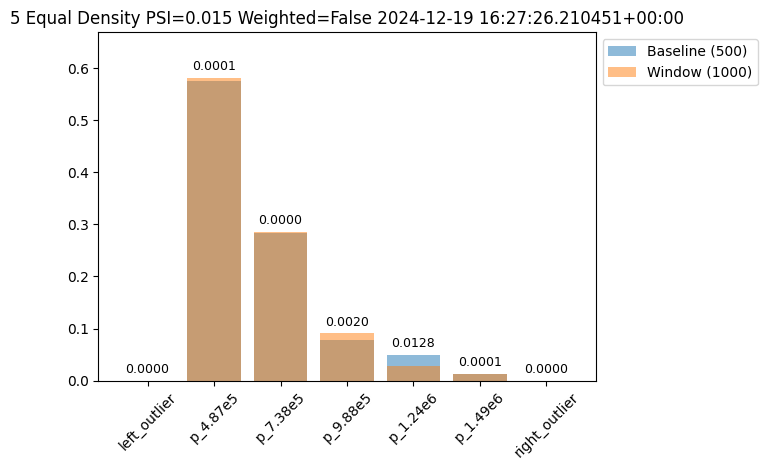

In [50]:
# Create the assay baseline
assay_baseline = wl.build_assay(assay_name=assay_name, 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# Set the assay parameters

# The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now())

# Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

# update binning mode here
assay_baseline.summarizer_builder.add_bin_mode(wallaroo.assay_config.BinMode.EQUAL)

# build the assay configuration
assay_config = assay_baseline.build()

# perform an interactive run and collect inference data
assay_results = assay_config.interactive_run()

# show one analysis with the updated bins
assay_results[0].chart()

The following example manually sets the bin values.

The values in this dataset run from 200000 to 1500000. We can specify the bins with the `BinMode.PROVIDED` and specifying a list of floats with the right hand / upper edge of each bin and optionally the lower edge of the smallest bin. If the lowest edge is not specified the threshold for left outliers is taken from the smallest value in the baseline dataset.

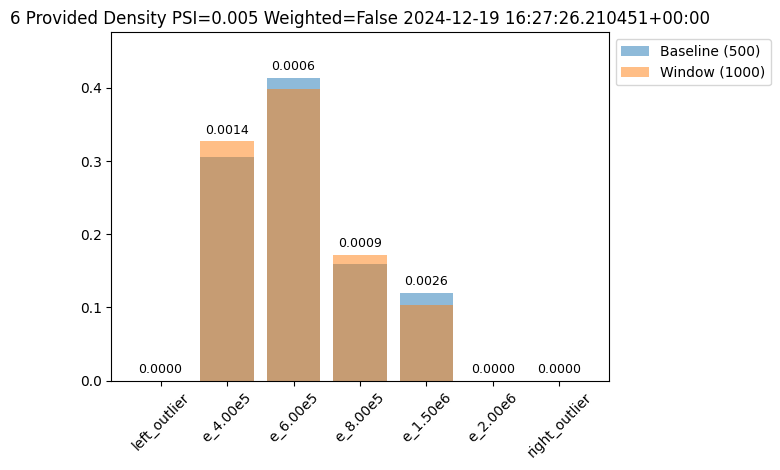

In [51]:
# Create the assay baseline
assay_baseline = wl.build_assay(assay_name=assay_name, 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# Set the assay parameters

# The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now())

# Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

edges = [200000.0, 400000.0, 600000.0, 800000.0, 1500000.0, 2000000.0]

# update binning mode here
assay_baseline.summarizer_builder.add_bin_mode(wallaroo.assay_config.BinMode.PROVIDED, edges)

# build the assay configuration
assay_config = assay_baseline.build()

# perform an interactive run and collect inference data
assay_results = assay_config.interactive_run()

# show one analysis with the updated bins
assay_results[0].chart()

##### Aggregation Options

Assay aggregation options are modified with the [`wallaroo.assay_config.AssayBuilder.add_aggregation(aggregation: wallaroo.assay_config.Aggregation)`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#UnivariateContinousSummarizerBuilder.add_aggregation) method.  The following options are provided:

* `Aggregation.DENSITY` (*Default*): Count the number/percentage of values that fall in each bin. 
* `Aggregation.CUMULATIVE`: Empirical Cumulative Density Function style, which keeps a cumulative count of the values/percentages that fall in each bin.

The following example demonstrate the different results between the two.

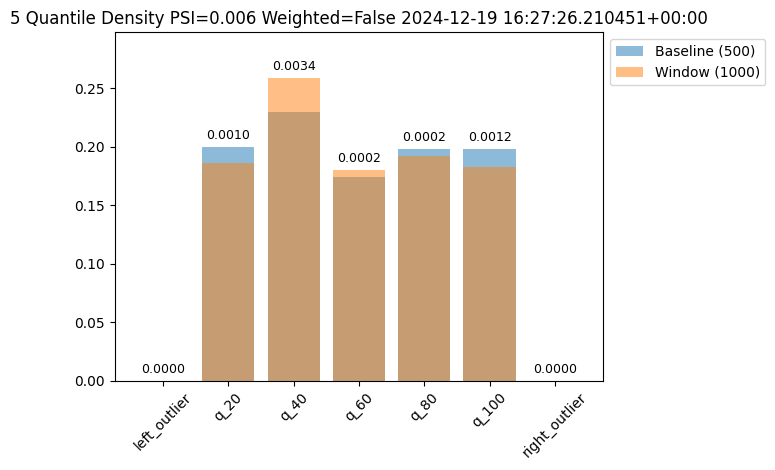

In [52]:
# Create the assay baseline
assay_baseline = wl.build_assay(assay_name=assay_name, 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# Set the assay parameters

# The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now())

# Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

#Aggregation.DENSITY - the default
assay_baseline.summarizer_builder.add_aggregation(wallaroo.assay_config.Aggregation.DENSITY)

# build the assay configuration
assay_config = assay_baseline.build()

# perform an interactive run and collect inference data
assay_results = assay_config.interactive_run()

# show one analysis with the updated bins
assay_results[0].chart()

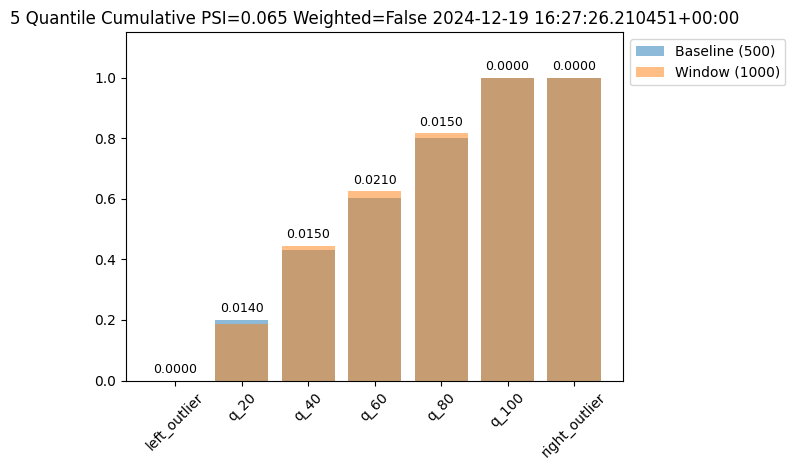

In [53]:
# Create the assay baseline
assay_baseline = wl.build_assay(assay_name=assay_name, 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)


# Set the assay parameters

# The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now())

# Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

#Aggregation.CUMULATIVE
assay_baseline.summarizer_builder.add_aggregation(wallaroo.assay_config.Aggregation.CUMULATIVE)

# build the assay configuration
assay_config = assay_baseline.build()

# perform an interactive run and collect inference data
assay_results = assay_config.interactive_run()

# show one analysis with the updated bins
assay_results[0].chart()

### Create Assay

With the assay previewed and configuration options determined, we officially create it by uploading it to the Wallaroo instance.

Once it is uploaded, the assay runs an analysis based on the window width, interval, and the other settings configured.

Assays are uploaded with the `wallaroo.assay_config.upload()` method. This uploads the assay into the Wallaroo database with the configurations applied and returns the assay id. Note that assay names **must be unique across the Wallaroo instance**; attempting to upload an assay with the same name as an existing one will return an error.

`wallaroo.assay_config.upload()` returns the assay id for the assay.

Typically we would just call `wallaroo.assay_config.upload()` after configuring the assay.  For the example below, we will perform the complete configuration in one window to show all of the configuration steps at once before creating the assay.

In [54]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_baseline = wl.build_assay(assay_name="assays from date baseline tutorial samples", 
                                          pipeline=mainpipeline, 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set the width, interval, and assay start date and time
assay_baseline.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

# add other options
assay_baseline.summarizer_builder.add_aggregation(wallaroo.assay_config.Aggregation.CUMULATIVE)
assay_baseline.summarizer_builder.add_metric(wallaroo.assay_config.Metric.MAXDIFF)
assay_baseline.add_alert_threshold(0.5)


assay_id = assay_baseline.upload()

# wait 65 seconds for the first analysis run performed
time.sleep(65)


The assay is now visible through the Wallaroo UI by selecting the workspace, then the pipeline, then **Insights**.

![Sample assay in the UI](images/housepricesaga-sample-assay.png)

### Get Assay Info

Assay information is retrieved with the `wallaroo.client.get_assay_info()` which takes the following parameters.

| Parameter | Type | Description |
|---|---|---|
| **assay_id** | *String* (*Required*) | The numerical id of the assay in UUID format. |
| **workspace_id** | (*Int*) (*Optional*) | The numerical identifier of the workspace to filter by. |
| **workspace_name** | (*String*) (*Optional*) | The name of the workspace to filter by. |


This returns the following:

| Parameter | Type | Description |
|---|---|---|
| *id* | *String* | The id of the assay in UUID format. |
| *name* | *String* | The name of the assay. |
| *active* | *Boolean* | `True`: The assay is active and generates analyses based on its configuration. `False`: The assay is disabled and will not generate new analyses. |
| *pipeline_name* | *String* | The name of the pipeline the assay references. |
| *last_run* | *DateTime* | The date and time the assay last ran. |
| *next_run* | *DateTime* | THe date and time the assay analysis will next run. |
| *alert_threshold* | *Float* | The alert threshold setting for the assay. |
| *baseline* | *Dict* | The baseline and settings as set from the assay configuration. |
| *iopath* | *String* | The `iopath` setting for the assay. |
| *metric* | *String* | The `metric` setting for the assay. |
| *num_bins* | *Integer* | The number of bins for the assay. |
| *bin_weights* | *List*/None | The bin weights used if any. |
| *bin_mode* | *String* | The binning mode used. |
| *workspace_id* | (*Int*) | The numerical identifier of the workspace the assay is associated with. |
| *workspace_name* | (*String*)  | The name of the workspace the assay is associated with. |


In [55]:
display(wl.get_assay_info(assay_id))

Field,Value
ID,a2a81e83-ce01-40f5-9323-c710dba454c8
Name,assays from date baseline tutorial samples
Active,True
Pipeline,assay-demonstration-tutorial
Workspace ID,9
Workspace Name,assay-demonstration-tutorial-2
Monitoring,['out.variable.0']
Window Width,60 seconds
First Run,2024-19-Dec 16:26:26
Run Frequency,1 Minute


### Get Assay Results

Once an assay is created the assay runs an analysis based on the window width, interval, and the other settings configured.

Assay results are retrieved with the `wallaroo.client.get_assay_results` method which takes the following parameters:

| Parameter | Type | Description |
|---|---|---|
| **assay_id** | *String* (*Required*) | The id of the assay in UUID format. |
| **start** | *Datetime.Datetime* (*Required*) | The start date and time of historical data from the pipeline to start analyses from. |
| **end** | *Datetime.Datetime* (*Required*) | The end date and time of historical data from the pipeline to limit analyses to. |
| **workspace_id** | (*Int*) (*Optional*) | The numerical identifier of the workspace to filter by. |
| **workspace_name** | (*String*) (*Optional*) | The name of the workspace to filter by. |

* **IMPORTANT NOTE**:  This process requires that additional historical data is generated from the time the assay is created to when the results are available. To add additional inference data, use the [Assay Test Data](#assay-test-data) section above.

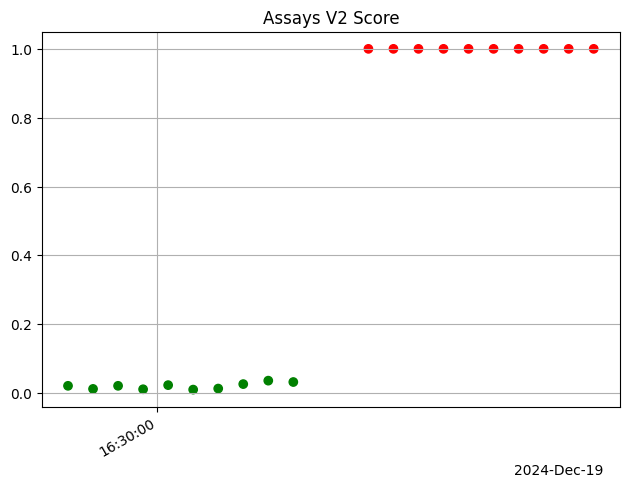

In [56]:
assay_results = wl.get_assay_results(assay_id=assay_id,
                     start=(datetime.datetime.now()-datetime.timedelta(days=2)),
                     end=datetime.datetime.now())

# Preview the assay analyses
assay_results.chart_scores()

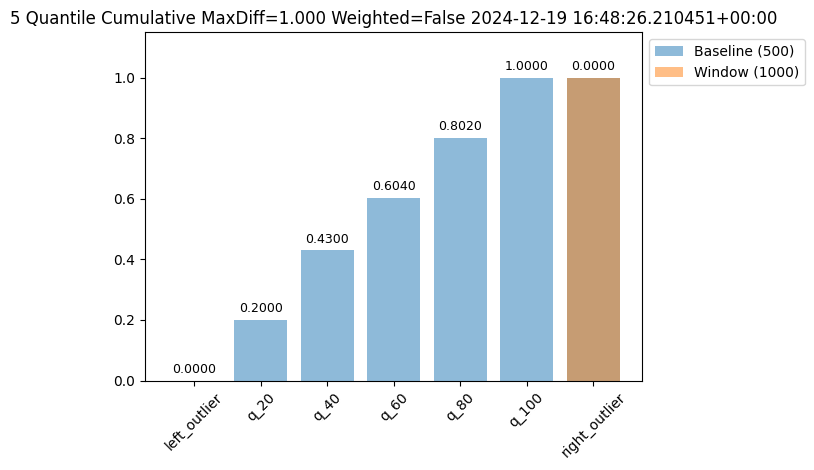

In [57]:
assay_results[0].chart()

### List Assays

A list of assays is retrieved with the `wallaroo.client.list_assays()` method and takes the following parameters:

| Parameter | Type | Description |
|---|---|---|
| **workspace_id** | (*Int*) (*Optional*) | The numerical identifier of the workspace to filter by. |
| **workspace_name** | (*String*) (*Optional*) | The name of the workspace to filter by. |

This returns a list of assays as filtered in reverse chronological order.

| Parameter | Type | Description |
|---|---|---|
| *Assay Id* | *String* | The id of the assay in UUID format. |
| *Assay Name* | *String* | The name of the assay. |
| *Active* | *Boolean* | `True`: The assay is active and generates analyses based on its configuration. `False`: The assay is disabled and will not generate new analyses. |
| *Status* | *Dict* | The status of the assay including the 
| *Warning Threshold* | *Float*/*None* | The warning threshold if set. |
| *Alert Threshold* | *Float* | The alert threshold for the assay. |
| *workspace_id* | (*Int*) | The numerical identifier of the workspace the assay is associated with. |
| *workspace_name* | (*String*)  | The name of the workspace the assay is associated with. |

The errors for this method include:

* If the parameter `workspace_id` is not an integer.
* If the parameter `workspace_name` is not a String.


In [58]:
wl.list_assays()

id,name,active,pipeline,workspace id,workspace name,monitored fields,last_run,next_run,created_at,updated_at
a2a81e83-ce01-40f5-9323-c710dba454c8,assays from date baseline tutorial samples,True,assay-demonstration-tutorial,9,assay-demonstration-tutorial-2,['out.variable.0'],2024-19-Dec 17:16:26,2024-19-Dec 17:17:26,2024-19-Dec 17:15:50,2024-19-Dec 17:15:50


### Set Assay Active Status

Assays active status is either:

* **True**:  The assay generates analyses based on the assay configuration.
* **False**:  The assay will not generate new analyses.

Assays are set to active or not active with the `wallaroo.client.set_assay_active` which takes the following parameters.

| Parameter | Type | Description |
|---|---|---|
| *assay_id* | *String* | The id of the assay in UUID format. |
| *active* | *Boolean* | `True`: The assay status is set to `Active`.  `False`: The assay status is `Not Active`. |

First we will show the current active status.

In the following, set the assay status to `False`, then set the assay active status back to `True`.

In [61]:
display(wl.get_assay_info(assay_id))

Field,Value
ID,a2a81e83-ce01-40f5-9323-c710dba454c8
Name,assays from date baseline tutorial samples
Active,True
Pipeline,assay-demonstration-tutorial
Workspace ID,9
Workspace Name,assay-demonstration-tutorial-2
Monitoring,['out.variable.0']
Window Width,60 seconds
First Run,2024-19-Dec 16:26:26
Run Frequency,1 Minute


Now we set the active status to `False`, and show the assay list to verify it is no longer active.

In [62]:
wl.set_assay_active(assay_id, False)
display(wl.get_assay_info(assay_id))

Field,Value
ID,a2a81e83-ce01-40f5-9323-c710dba454c8
Name,assays from date baseline tutorial samples
Active,False
Pipeline,assay-demonstration-tutorial
Workspace ID,9
Workspace Name,assay-demonstration-tutorial-2
Monitoring,['out.variable.0']
Window Width,60 seconds
First Run,2024-19-Dec 16:26:26
Run Frequency,1 Minute


We resume the assay by setting it's active status to `True`.

In [63]:
wl.set_assay_active(assay_id, True)
display(wl.get_assay_info(assay_id))

Field,Value
ID,a2a81e83-ce01-40f5-9323-c710dba454c8
Name,assays from date baseline tutorial samples
Active,True
Pipeline,assay-demonstration-tutorial
Workspace ID,9
Workspace Name,assay-demonstration-tutorial-2
Monitoring,['out.variable.0']
Window Width,60 seconds
First Run,2024-19-Dec 16:26:26
Run Frequency,1 Minute


### Undeploy Main Pipeline

With the examples and tutorial complete, we will undeploy the main pipeline and return the resources back to the Wallaroo instance.

In [64]:
mainpipeline.undeploy()

Waiting for undeployment - this will take up to 45s ...... ok


name,assay-demonstration-tutorial
created,2024-12-19 16:23:10.022182+00:00
last_updated,2024-12-19 16:23:10.092884+00:00
deployed,False
workspace_id,9
workspace_name,assay-demonstration-tutorial-2
arch,x86
accel,none
tags,
versions,"891c2825-2a2a-41d5-9cc0-d163eba07225, 3d26461a-a803-4309-a956-3d1248b2d7af"
steps,house-price-estimator


### View Assay Filters

The following examples demonstrate various ways of listing assays and retrieving assay details, with filtering options.

#### List Assays with Filters

List all assays for workspaces the user is a member of.

In [65]:
wl.list_assays()

id,name,active,pipeline,workspace id,workspace name,monitored fields,last_run,next_run,created_at,updated_at
a2a81e83-ce01-40f5-9323-c710dba454c8,assays from date baseline tutorial samples,True,assay-demonstration-tutorial,9,assay-demonstration-tutorial-2,['out.variable.0'],2024-19-Dec 17:19:26,2024-19-Dec 17:20:26,2024-19-Dec 17:15:50,2024-19-Dec 17:18:54


List all assays filtered by workspace id.

In [66]:
wl.list_assays(workspace_id=workspace_id)

id,name,active,pipeline,workspace id,workspace name,monitored fields,last_run,next_run,created_at,updated_at
a2a81e83-ce01-40f5-9323-c710dba454c8,assays from date baseline tutorial samples,True,assay-demonstration-tutorial,9,assay-demonstration-tutorial-2,['out.variable.0'],2024-19-Dec 17:19:26,2024-19-Dec 17:20:26,2024-19-Dec 17:15:50,2024-19-Dec 17:18:54


List assays filtered by workspace name.

In [67]:
wl.list_assays(workspace_name=workspace_name)

id,name,active,pipeline,workspace id,workspace name,monitored fields,last_run,next_run,created_at,updated_at
a2a81e83-ce01-40f5-9323-c710dba454c8,assays from date baseline tutorial samples,True,assay-demonstration-tutorial,9,assay-demonstration-tutorial-2,['out.variable.0'],2024-19-Dec 17:19:26,2024-19-Dec 17:20:26,2024-19-Dec 17:15:50,2024-19-Dec 17:18:54


#### Get Assay Results with Filters

Get assay results.

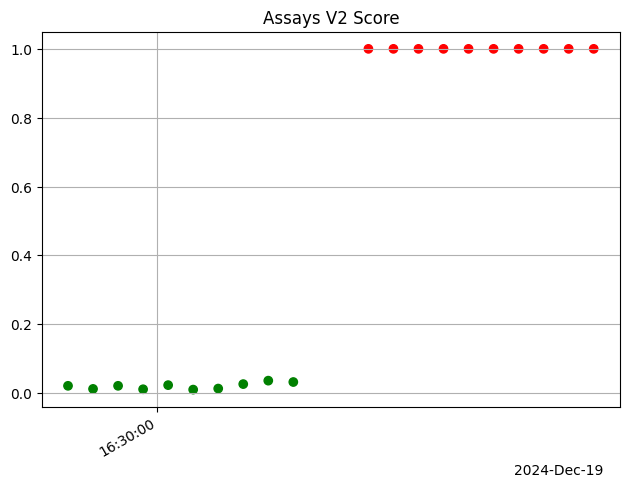

In [68]:
assay_results = wl.get_assay_results(assay_id=assay_id,
                     start=assay_window_start,
                     end=datetime.datetime.now())

assay_results.chart_scores()

Get assay results filtered by workspace id.

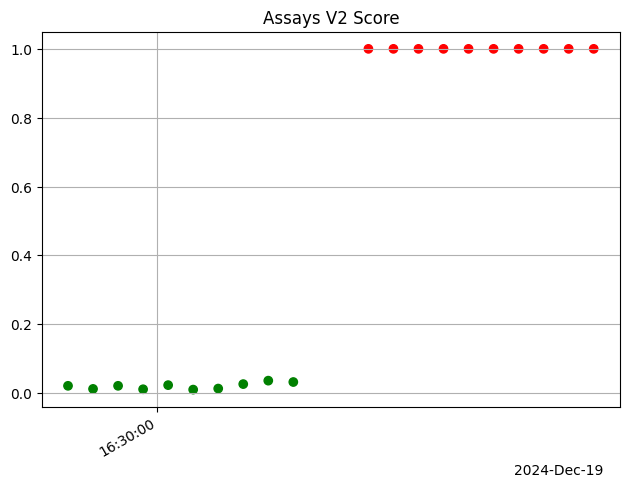

In [69]:
assay_results = wl.get_assay_results(assay_id=assay_id,
                                     workspace_id=workspace_id,
                     start=assay_window_start,
                     end=datetime.datetime.now())

assay_results.chart_scores()

Get assay results filtered by workspace name.

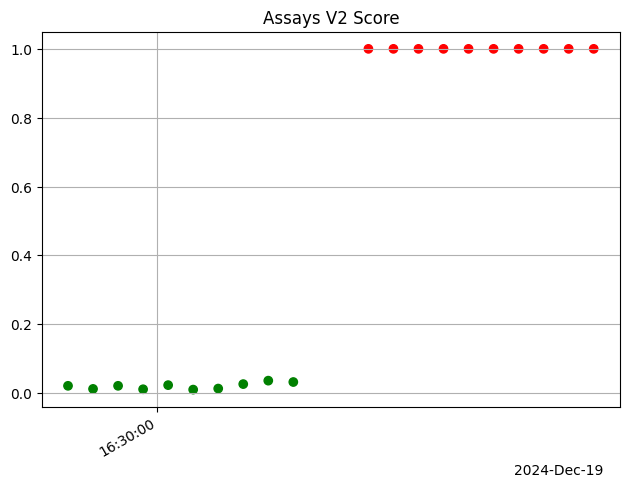

In [70]:
assay_results = wl.get_assay_results(assay_id=assay_id,
                                     workspace_name=workspace_name,
                     start=assay_window_start,
                     end=datetime.datetime.now())

assay_results.chart_scores()

#### Get Assay Info with Filter

Get assay info.

In [71]:
wl.get_assay_info(assay_id=assay_id)

Field,Value
ID,a2a81e83-ce01-40f5-9323-c710dba454c8
Name,assays from date baseline tutorial samples
Active,True
Pipeline,assay-demonstration-tutorial
Workspace ID,9
Workspace Name,assay-demonstration-tutorial-2
Monitoring,['out.variable.0']
Window Width,60 seconds
First Run,2024-19-Dec 16:26:26
Run Frequency,1 Minute


Get assay info filtered by workspace id.

In [72]:
wl.get_assay_info(assay_id=assay_id, 
                 workspace_id=workspace_id)

Field,Value
ID,a2a81e83-ce01-40f5-9323-c710dba454c8
Name,assays from date baseline tutorial samples
Active,True
Pipeline,assay-demonstration-tutorial
Workspace ID,9
Workspace Name,assay-demonstration-tutorial-2
Monitoring,['out.variable.0']
Window Width,60 seconds
First Run,2024-19-Dec 16:26:26
Run Frequency,1 Minute


Get assay info filtered by workspace name.

In [73]:
wl.get_assay_info(assay_id=assay_id, 
                 workspace_name=workspace_name)

Field,Value
ID,a2a81e83-ce01-40f5-9323-c710dba454c8
Name,assays from date baseline tutorial samples
Active,True
Pipeline,assay-demonstration-tutorial
Workspace ID,9
Workspace Name,assay-demonstration-tutorial-2
Monitoring,['out.variable.0']
Window Width,60 seconds
First Run,2024-19-Dec 16:26:26
Run Frequency,1 Minute
